This notebook deals with weather forecasting data for a specific location for the years 2023, 2024, 2025.

It starts with extensive EDA to understand the data and the patterns of the features.
After data preprocessing, I tried building different models for the best results.

# Setting The Notebook

In [1]:
!pip install dcor

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import glob
import os
import dcor
import joblib
import random

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, GRU, TimeDistributed, RepeatVector, MaxPooling1D, Conv1D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-09-23 12:13:20.105853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758629600.296933     104 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758629600.353247     104 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
np.random.seed(42)
tf.random.set_seed(42)

# 1. Data Overview

In [5]:
# Downloading the CSV file
# https://drive.google.com/file/d/1Z2j9yy6OVS6H-oFuxd4SGQR9y0g0BNm-/view?usp=sharing
# file_id = "128lLQuoZu5zPSDuJ-YlC29ZJoe9CehFc" #Data from 21 to 25, Notebook crashed
# file_id = "1aTJM0_vnwGaZByl6NtjB2_IIk1wNFKDf" #Data from 22 to 25, Notebook crashed
file_id = "1Z2j9yy6OVS6H-oFuxd4SGQR9y0g0BNm-"
gdown_link = f"https://drive.google.com/uc?id={file_id}"

path = "/kaggle/working/data.csv"
gdown.download(gdown_link, path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Z2j9yy6OVS6H-oFuxd4SGQR9y0g0BNm-
To: /kaggle/working/data.csv
100%|██████████| 1.84M/1.84M [00:00<00:00, 143MB/s]


'/kaggle/working/data.csv'

In [6]:
df = pd.read_csv(path)
df.head()

valid_time  temperature_C  pressure_hPa  humidity_%  \
0  2023-01-01 00:00:00      12.756500    1010.58124   79.738754   
1  2023-01-01 01:00:00      12.593414    1010.27185   80.456370   
2  2023-01-01 02:00:00      11.921295    1009.95874   79.984800   
3  2023-01-01 03:00:00      11.582428    1009.84750   80.606670   
4  2023-01-01 04:00:00      12.017487    1010.04315   78.757800   

   wind_speed_mps  wind_dir_deg  solar_radiation_Wm2  rain_mm_h  
0        3.468907     357.04996                  0.0        0.0  
1        3.658261     353.96478                  0.0        0.0  
2        3.759195     352.78160                  0.0        0.0  
3        3.705409     352.17070                  0.0        0.0  
4        3.655312     352.34924                  0.0        0.0

In [7]:
df.shape

(23073, 8)

In [8]:
# Convert and sort by valid_time
df['valid_time'] = pd.to_datetime(df['valid_time'])
df = df.sort_values(by='valid_time').reset_index(drop=True)
df.set_index('valid_time', inplace=True)

In [9]:
df.shape

(23073, 7)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23073 entries, 2023-01-01 00:00:00 to 2025-08-19 08:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperature_C        23073 non-null  float64
 1   pressure_hPa         23073 non-null  float64
 2   humidity_%           23073 non-null  float64
 3   wind_speed_mps       23073 non-null  float64
 4   wind_dir_deg         23073 non-null  float64
 5   solar_radiation_Wm2  23073 non-null  float64
 6   rain_mm_h            23073 non-null  float64
dtypes: float64(7)
memory usage: 1.4 MB


In [11]:
df.describe().T

count         mean         std         min         25%  \
temperature_C        23073.0    23.129514    7.411610    5.787506   17.391266   
pressure_hPa         23073.0  1001.419704    5.191756  987.197500  997.411870   
humidity_%           23073.0    53.461348   19.621414    7.105727   37.058200   
wind_speed_mps       23073.0     3.477942    1.411445    0.029192    2.446113   
wind_dir_deg         23073.0   215.171436  136.772630    0.003021   43.653168   
solar_radiation_Wm2  23073.0   253.078340  330.087765    0.000000    0.000000   
rain_mm_h            23073.0     0.002003    0.028676    0.000000    0.000000   

                             50%          75%          max  
temperature_C          23.072418    28.489655    42.462800  
pressure_hPa         1001.110600  1005.296900  1016.727500  
humidity_%             51.711876    70.184480    98.632965  
wind_speed_mps          3.346126     4.400808    10.356004  
wind_dir_deg          287.019170   333.560940   359.998540  
solar_radiation_Wm2    18.648890   518.862240  1032.088900  
rain_mm_h               0.000000     0.000000     1.458168

In [12]:
df.columns

Index(['temperature_C', 'pressure_hPa', 'humidity_%', 'wind_speed_mps',
       'wind_dir_deg', 'solar_radiation_Wm2', 'rain_mm_h'],
      dtype='object')

In [13]:
# make sure it's hourly data, and no missing hours
print(pd.infer_freq(df.index))

h


In [14]:
df.isnull().any()

temperature_C          False
pressure_hPa           False
humidity_%             False
wind_speed_mps         False
wind_dir_deg           False
solar_radiation_Wm2    False
rain_mm_h              False
dtype: bool

In [15]:
df.duplicated().any()

False

# 2. Data Analysis

In [16]:
df.columns.tolist()

['temperature_C',
 'pressure_hPa',
 'humidity_%',
 'wind_speed_mps',
 'wind_dir_deg',
 'solar_radiation_Wm2',
 'rain_mm_h']

In [17]:
weather_cols = ['temperature_C', 'pressure_hPa', 'humidity_%', 'wind_speed_mps', 
            'wind_dir_deg', 'solar_radiation_Wm2', 'rain_mm_h']
weather_cols

['temperature_C',
 'pressure_hPa',
 'humidity_%',
 'wind_speed_mps',
 'wind_dir_deg',
 'solar_radiation_Wm2',
 'rain_mm_h']

## 2.1 Features Overview

In [18]:
def get_general_info(data, features):
    for feat in features:
        avg = data[feat].mean()
        minVal = data[feat].min()
        maxVal = data[feat].max()

        print(f'For feature {feat}:')
        print(f'Average Value: {avg}')
        print(f'Minimum Value: {minVal}')
        print(f'Maximum Value: {maxVal}')
        print('-'*20)

get_general_info(df, weather_cols)

For feature temperature_C:
Average Value: 23.129514440969967
Minimum Value: 5.787506
Maximum Value: 42.4628
--------------------
For feature pressure_hPa:
Average Value: 1001.4197044337537
Minimum Value: 987.1975
Maximum Value: 1016.7275
--------------------
For feature humidity_%:
Average Value: 53.46134783151303
Minimum Value: 7.1057267
Maximum Value: 98.632965
--------------------
For feature wind_speed_mps:
Average Value: 3.477941594858276
Minimum Value: 0.029191686
Maximum Value: 10.356004
--------------------
For feature wind_dir_deg:
Average Value: 215.17143595386153
Minimum Value: 0.0030212402
Maximum Value: 359.99854
--------------------
For feature solar_radiation_Wm2:
Average Value: 253.0783403548743
Minimum Value: 0.0
Maximum Value: 1032.0889
--------------------
For feature rain_mm_h:
Average Value: 0.0020032823212126727
Minimum Value: 0.0
Maximum Value: 1.458168
--------------------


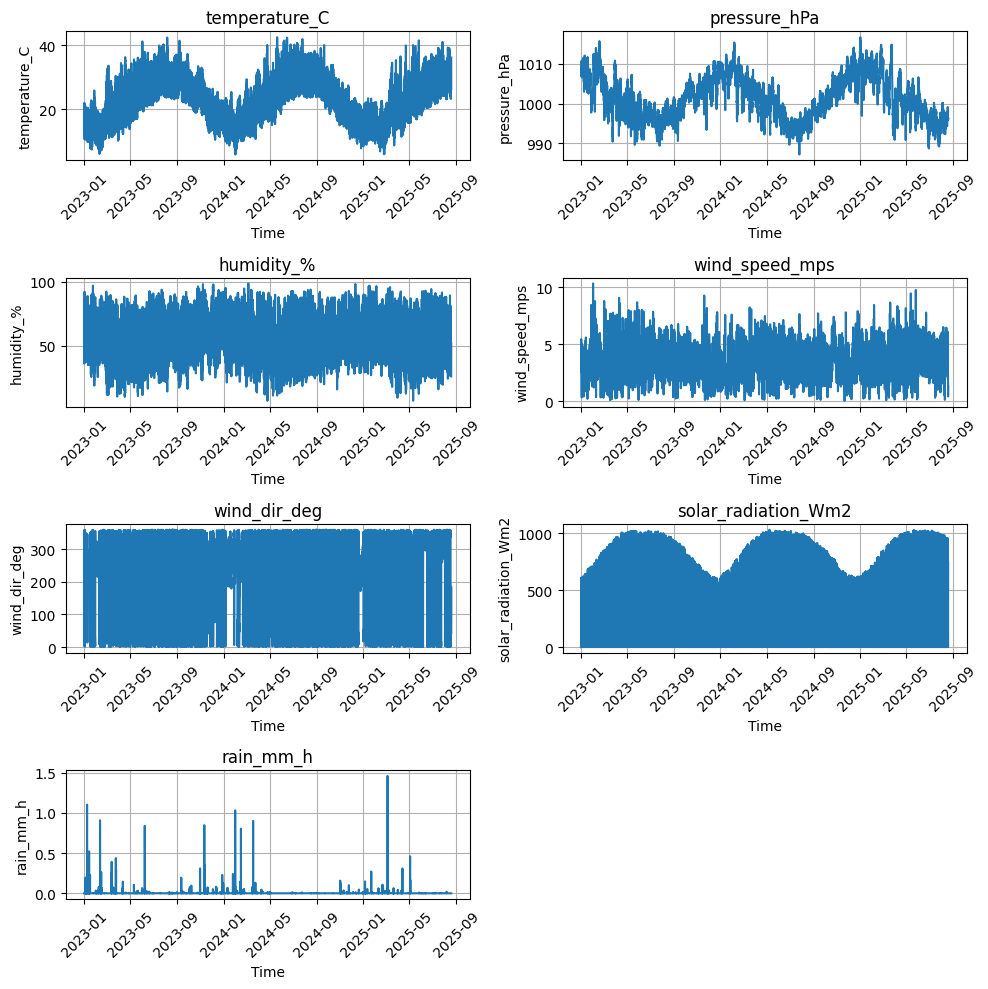

In [19]:
'''
Trying first to subplot all values for the features
Not helpful, will specify single hour
'''
plt.figure(figsize=(10,10))
for i, feat in enumerate(weather_cols, 1):
    plt.subplot(4, 2, i)
    plt.plot(df.index, df[feat])
    plt.title(feat)
    plt.xlabel("Time")
    plt.ylabel(feat)
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.show()

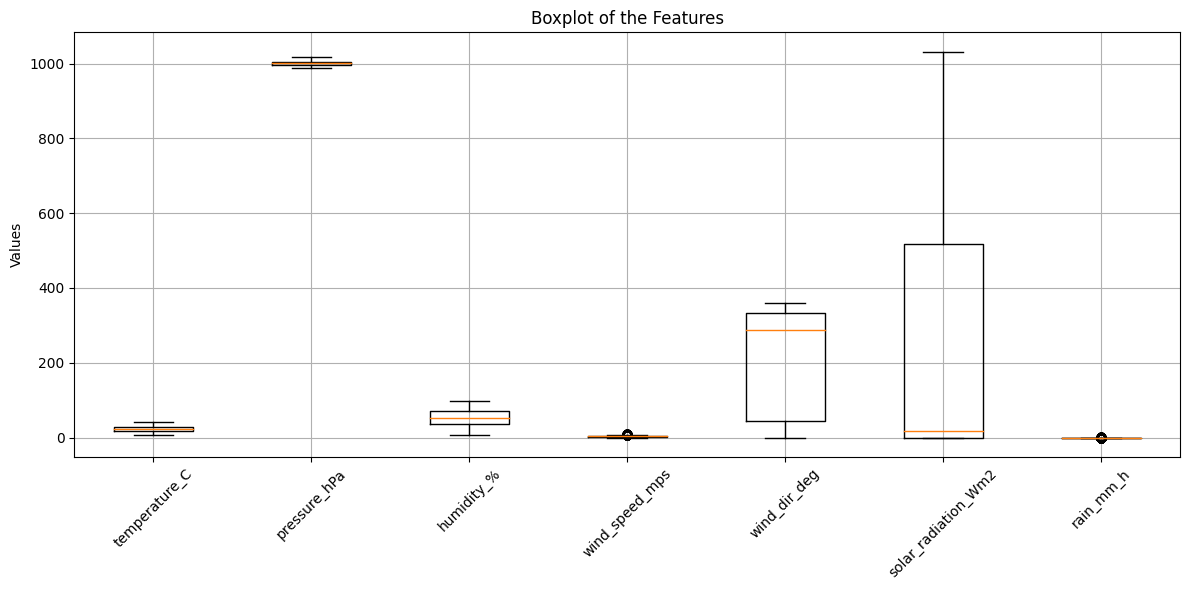

In [20]:
# BoxPlot for the features
plt.figure(figsize=(12, 6))
plt.boxplot(df[weather_cols], labels=weather_cols)

# Labeling
plt.title("Boxplot of the Features")
plt.ylabel("Values")
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

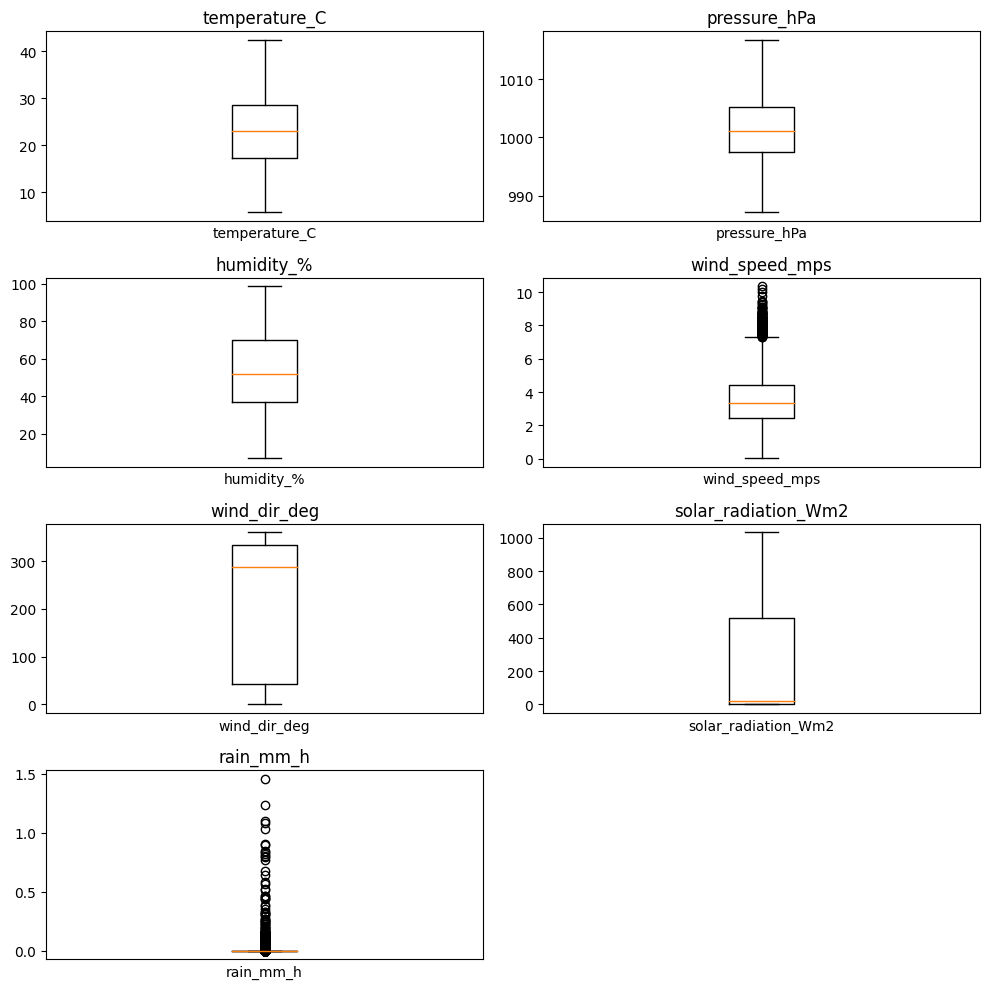

In [21]:
plt.figure(figsize=(10,10))
for i, feat in enumerate(weather_cols, 1):
    plt.subplot(4, 2, i)
    plt.boxplot(df[feat])
    plt.title(feat)
    plt.xlabel(feat)
    plt.xticks([])
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 2.2 Detecting Anomalies

Processing temperature_C...


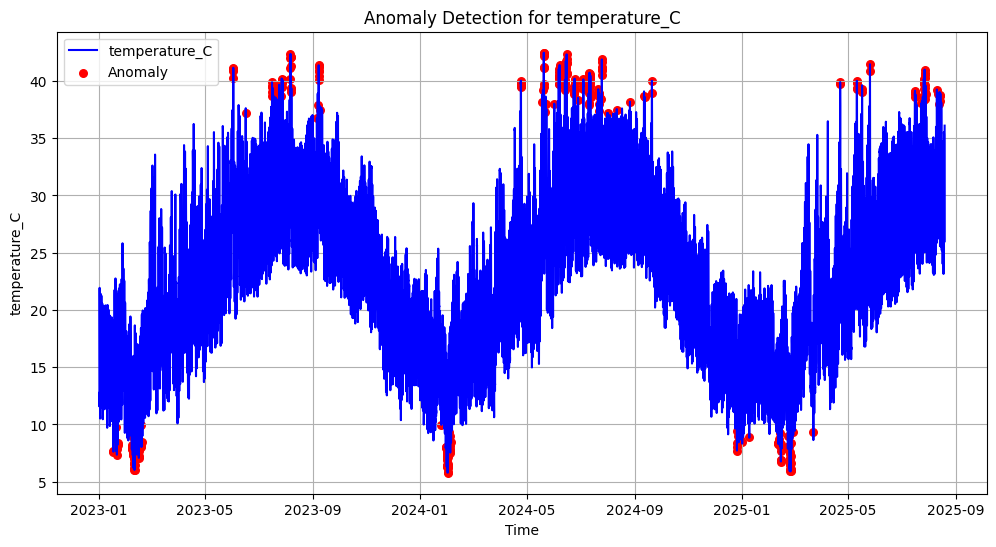

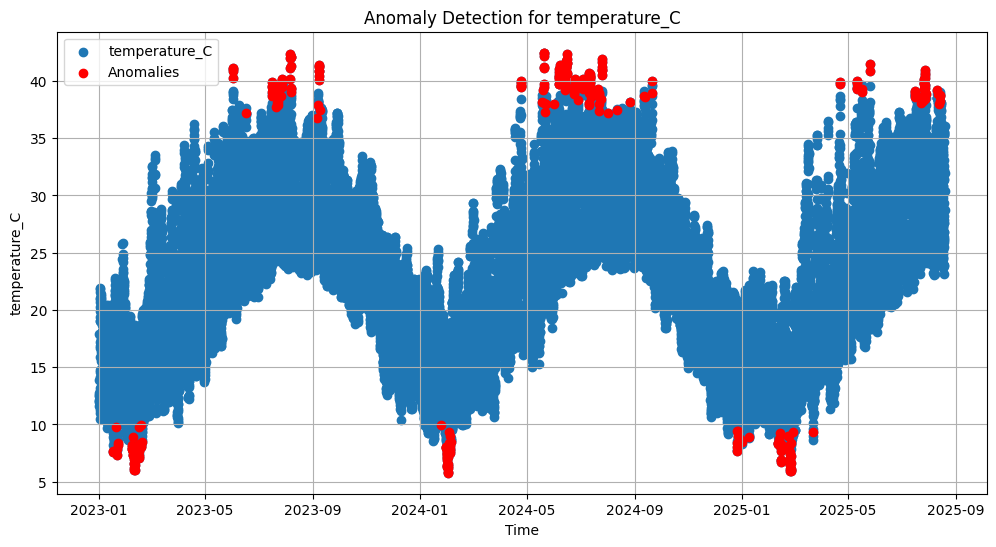

Processing pressure_hPa...


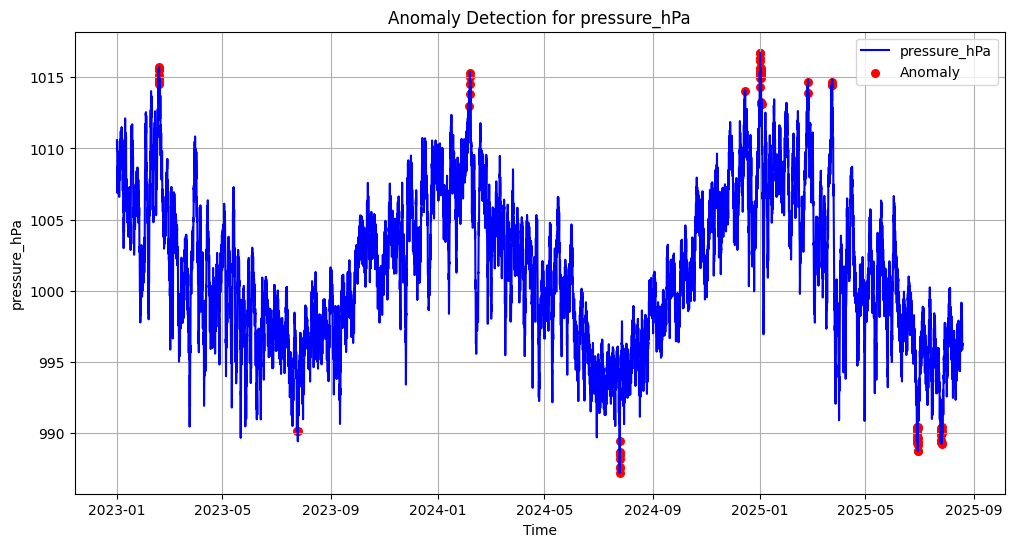

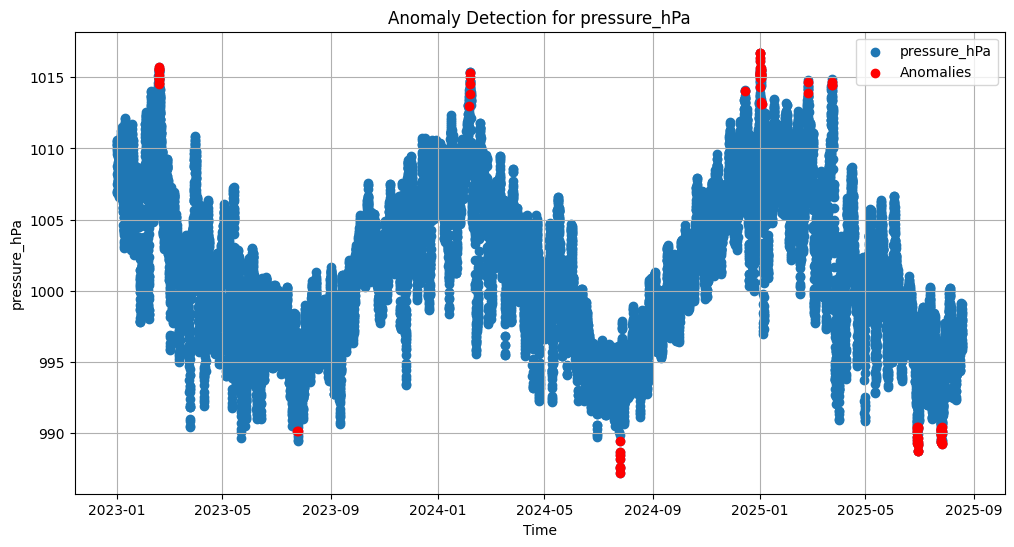

Processing humidity_%...


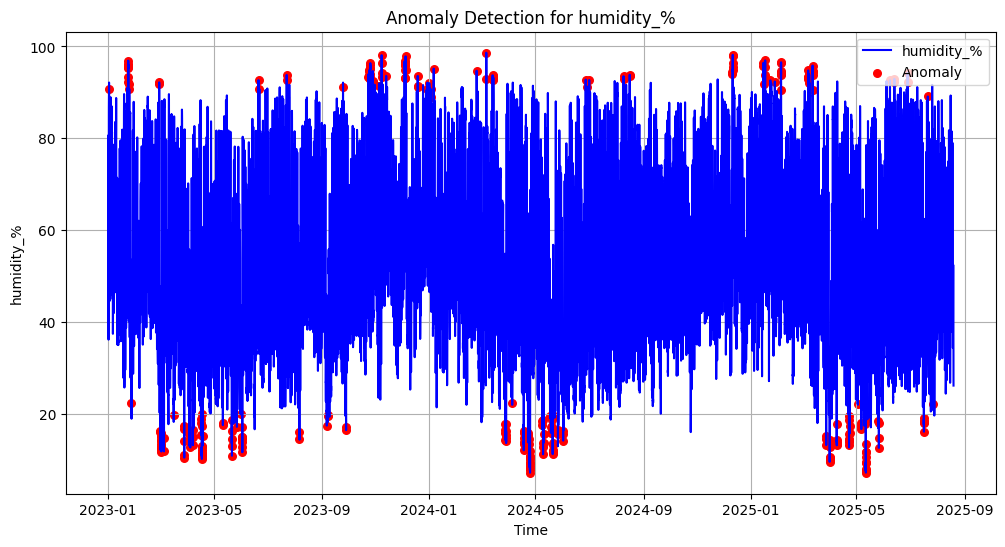

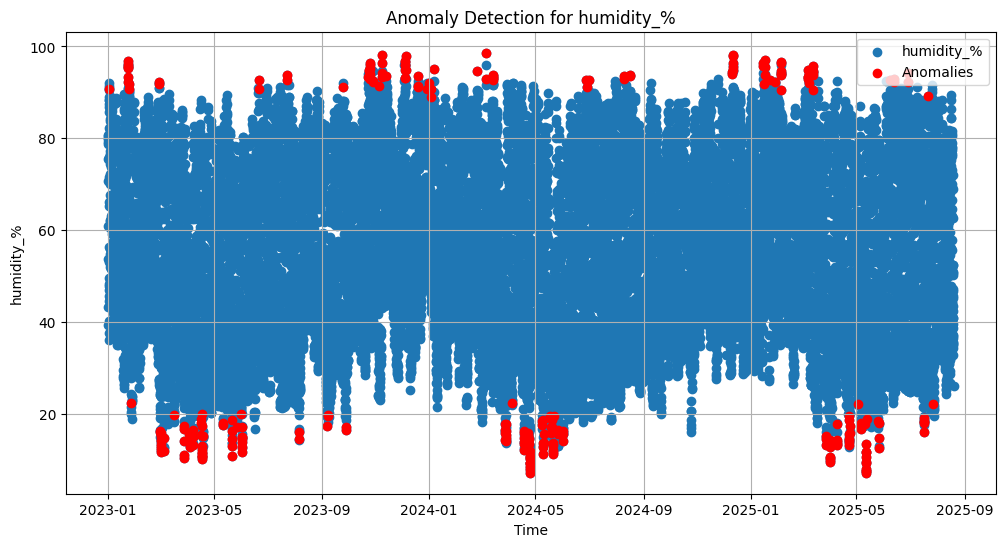

Processing wind_speed_mps...


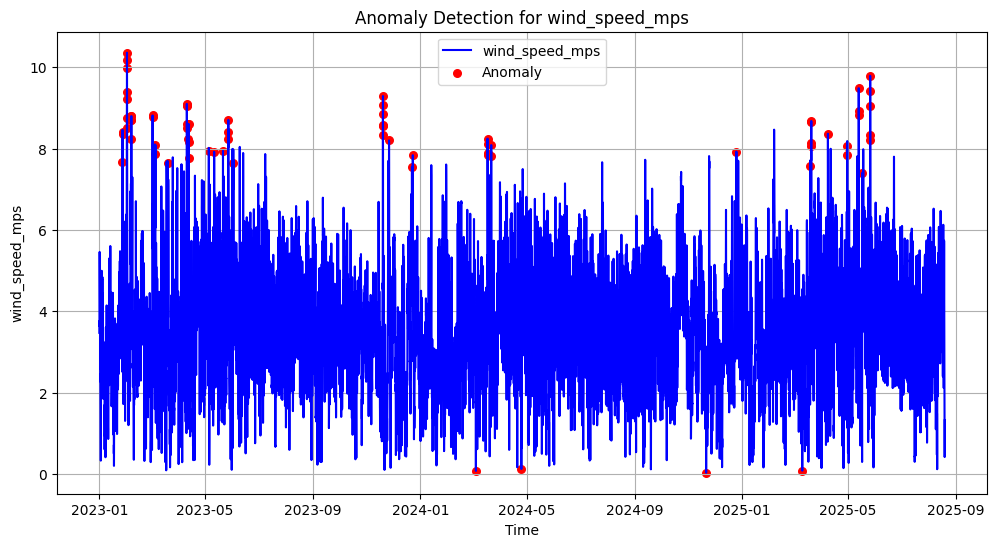

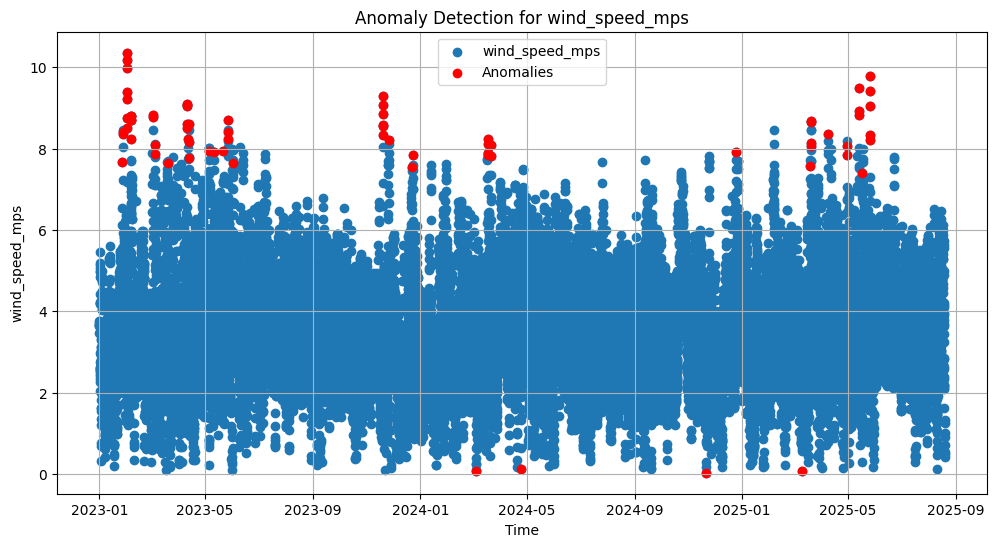

Processing wind_dir_deg...


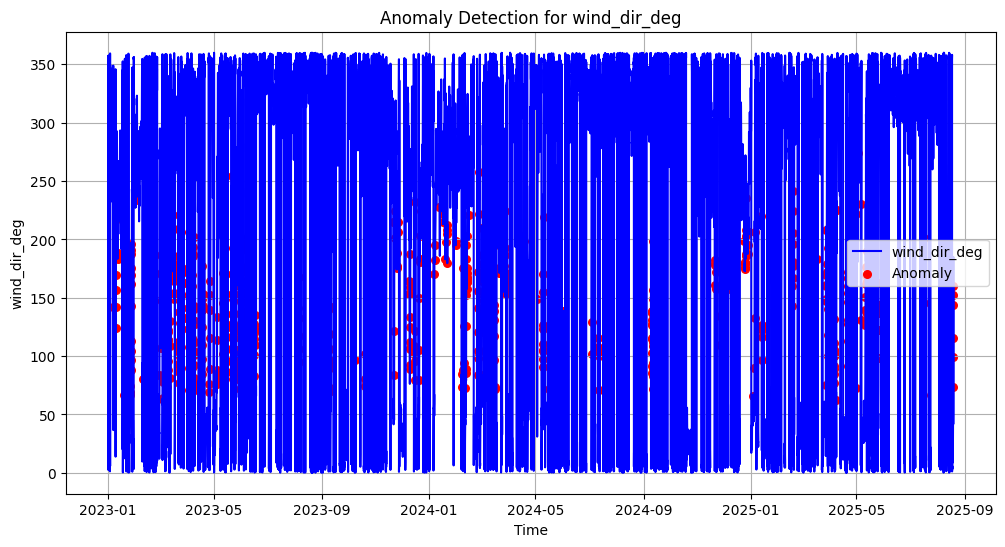

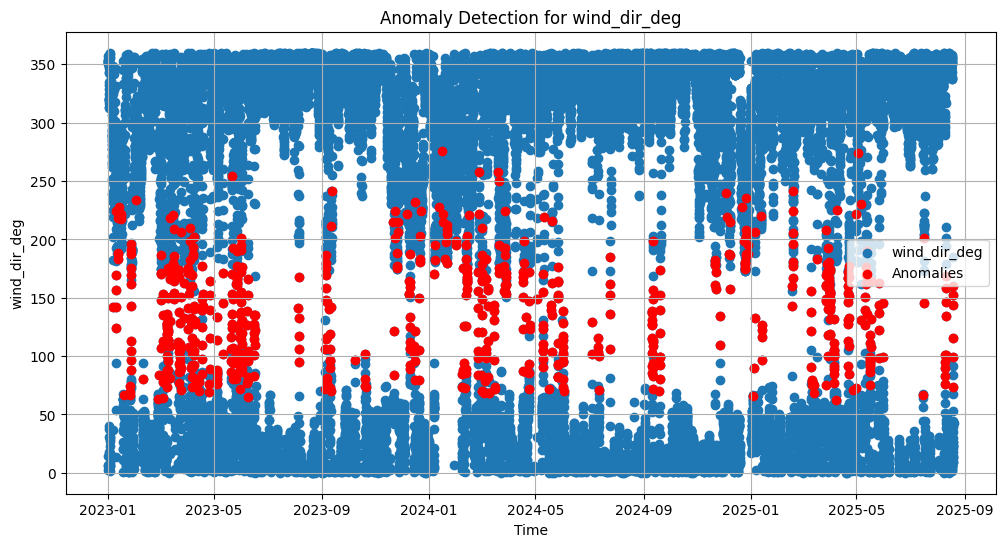

Processing solar_radiation_Wm2...


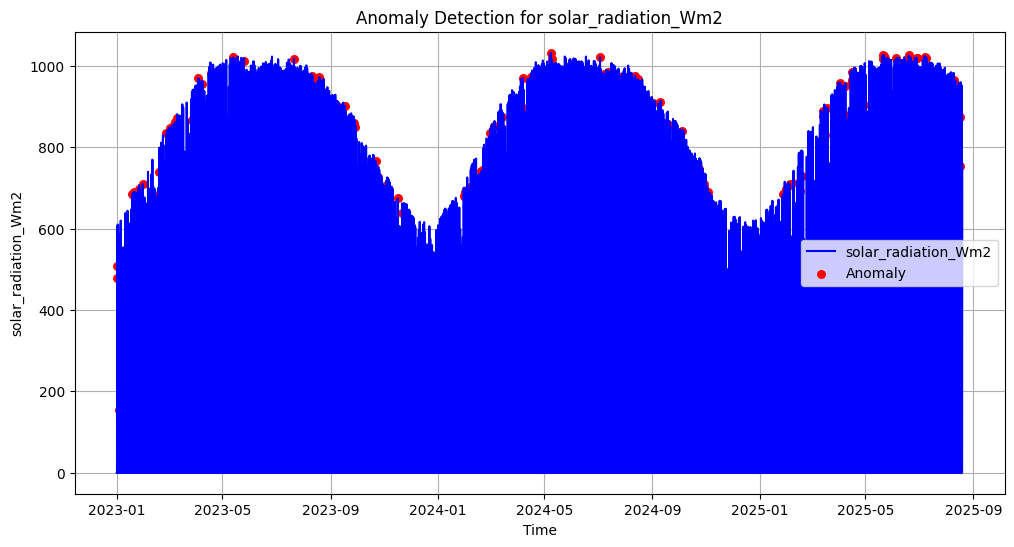

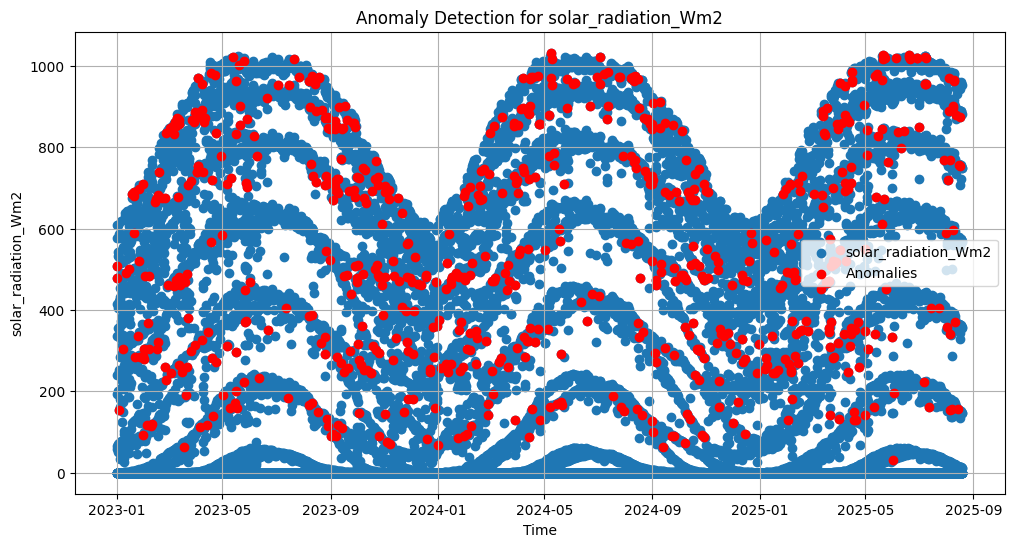

Processing rain_mm_h...


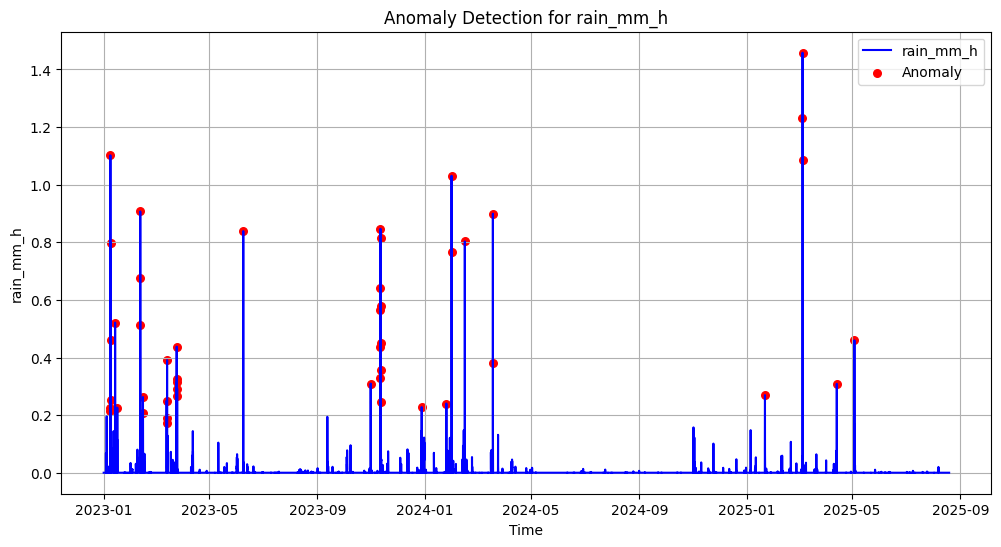

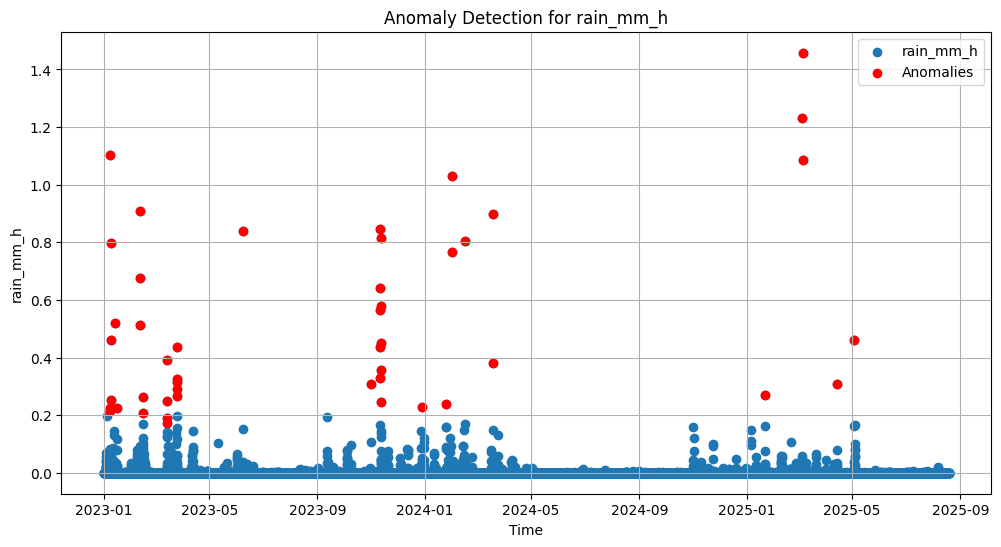

In [22]:
anomaly_thr = 2.0
anomaly_flags = pd.DataFrame(index=df.index)

for feat in weather_cols:
    print(f"Processing {feat}...")
    
    # Scaling
    sc = StandardScaler()
    scaled_feat = sc.fit_transform(df[[feat]])
    
    knn = NearestNeighbors(n_neighbors=5)
    knn.fit(scaled_feat)

    # Z-score
    distances, _ = knn.kneighbors(scaled_feat)
    avg_distances = distances.mean(axis=1)
    dist_mean = avg_distances.mean()
    dist_std = avg_distances.std()
    # z_scores = (avg_distances - avg_distances.mean()) / avg_distances.std()
    z_scores = (avg_distances - dist_mean) / dist_std
    
    anomaly_flags[feat + "_anomaly"] = (z_scores > anomaly_thr).astype(int)

    # Save everything in a dict & load it
    detector = {
        'scaler': sc,
        'knn': knn,
        'dist_mean': dist_mean,
        'dist_std': dist_std
    }
    joblib.dump(detector, f'{feat}_anomaly_detector.pkl')

    
    # Graph data points
    plt.figure(figsize=(12, 6))
    # plt.scatter(df.index, df[feat], label=feat)
    # plt.scatter(df.index[z_scores > anomaly_thr],
    #             df[feat][z_scores > anomaly_thr], 
    #             c='red', label='Anomalies')
    plt.plot(df.index, df[feat], label=feat, color="blue")
    plt.scatter(
        df.index[z_scores > anomaly_thr],
        df[feat][z_scores > anomaly_thr],
        color="red",
        label="Anomaly",
        s=30
    )
    plt.title(f"Anomaly Detection for {feat}")
    plt.xlabel("Time")
    plt.ylabel(feat)
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.scatter(df.index, df[feat], label=feat)
    plt.scatter(df.index[z_scores > anomaly_thr],
                df[feat][z_scores > anomaly_thr], 
                c='red', label='Anomalies')

    plt.title(f"Anomaly Detection for {feat}")
    plt.xlabel("Time")
    plt.ylabel(feat)
    plt.grid(True)
    plt.legend()
    plt.show()

# Add it as new feature if any other feature is anomaly 
df["anomaly"] = anomaly_flags.max(axis=1)

I tried to visualize each feature whether plotting the data or scatter to identify any pattern and reocgnize it.

In [23]:
df.head()

temperature_C  pressure_hPa  humidity_%  wind_speed_mps  \
valid_time                                                                     
2023-01-01 00:00:00      12.756500    1010.58124   79.738754        3.468907   
2023-01-01 01:00:00      12.593414    1010.27185   80.456370        3.658261   
2023-01-01 02:00:00      11.921295    1009.95874   79.984800        3.759195   
2023-01-01 03:00:00      11.582428    1009.84750   80.606670        3.705409   
2023-01-01 04:00:00      12.017487    1010.04315   78.757800        3.655312   

                     wind_dir_deg  solar_radiation_Wm2  rain_mm_h  anomaly  
valid_time                                                                  
2023-01-01 00:00:00     357.04996                  0.0        0.0        0  
2023-01-01 01:00:00     353.96478                  0.0        0.0        0  
2023-01-01 02:00:00     352.78160                  0.0        0.0        0  
2023-01-01 03:00:00     352.17070                  0.0        0.0        0  
2023-01-01 04:00:00     352.34924                  0.0        0.0        0

## 2.3 Time-Based Features

In [24]:
# Extract the time based features
df["hour"] = df.index.hour
df["month"] = df.index.month
df["date"] = df.index.date
df['WeekDay'] = df.index.dayofweek #(0:Monday, 6:Sunday)
df['YearDay'] = df.index.dayofyear
df['quarter'] = df.index.quarter

In [25]:
df.head()

temperature_C  pressure_hPa  humidity_%  wind_speed_mps  \
valid_time                                                                     
2023-01-01 00:00:00      12.756500    1010.58124   79.738754        3.468907   
2023-01-01 01:00:00      12.593414    1010.27185   80.456370        3.658261   
2023-01-01 02:00:00      11.921295    1009.95874   79.984800        3.759195   
2023-01-01 03:00:00      11.582428    1009.84750   80.606670        3.705409   
2023-01-01 04:00:00      12.017487    1010.04315   78.757800        3.655312   

                     wind_dir_deg  solar_radiation_Wm2  rain_mm_h  anomaly  \
valid_time                                                                   
2023-01-01 00:00:00     357.04996                  0.0        0.0        0   
2023-01-01 01:00:00     353.96478                  0.0        0.0        0   
2023-01-01 02:00:00     352.78160                  0.0        0.0        0   
2023-01-01 03:00:00     352.17070                  0.0        0.0        0   
2023-01-01 04:00:00     352.34924                  0.0        0.0        0   

                     hour  month        date  WeekDay  YearDay  quarter  
valid_time                                                               
2023-01-01 00:00:00     0      1  2023-01-01        6        1        1  
2023-01-01 01:00:00     1      1  2023-01-01        6        1        1  
2023-01-01 02:00:00     2      1  2023-01-01        6        1        1  
2023-01-01 03:00:00     3      1  2023-01-01        6        1        1  
2023-01-01 04:00:00     4      1  2023-01-01        6        1        1

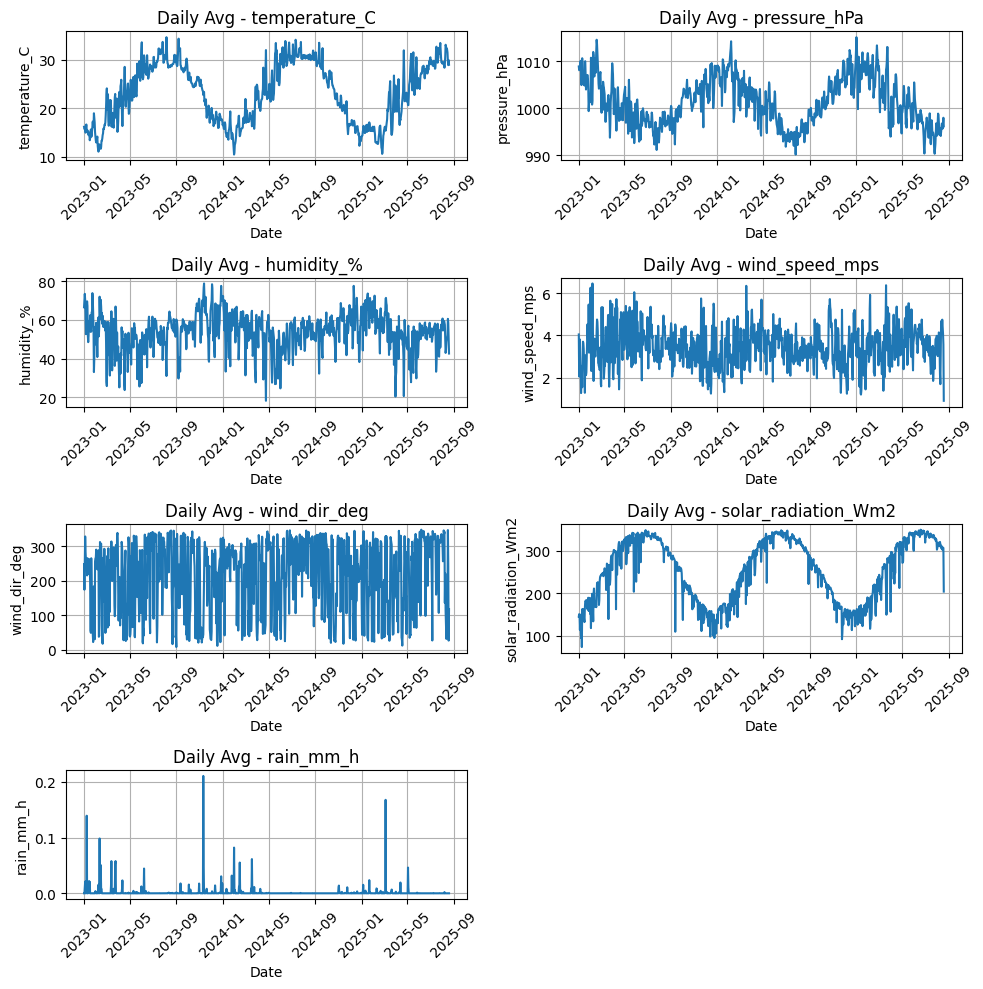

In [26]:
# Graph the daily avg value
daily_avg = df.groupby("date")[weather_cols].mean().reset_index()

plt.figure(figsize=(10, 10))
for i, feat in enumerate(weather_cols, 1):
    plt.subplot(4, 2, i)
    plt.plot(daily_avg["date"], daily_avg[feat])
    plt.title(f"Daily Avg - {feat}")
    plt.xlabel("Date")
    plt.ylabel(feat)
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

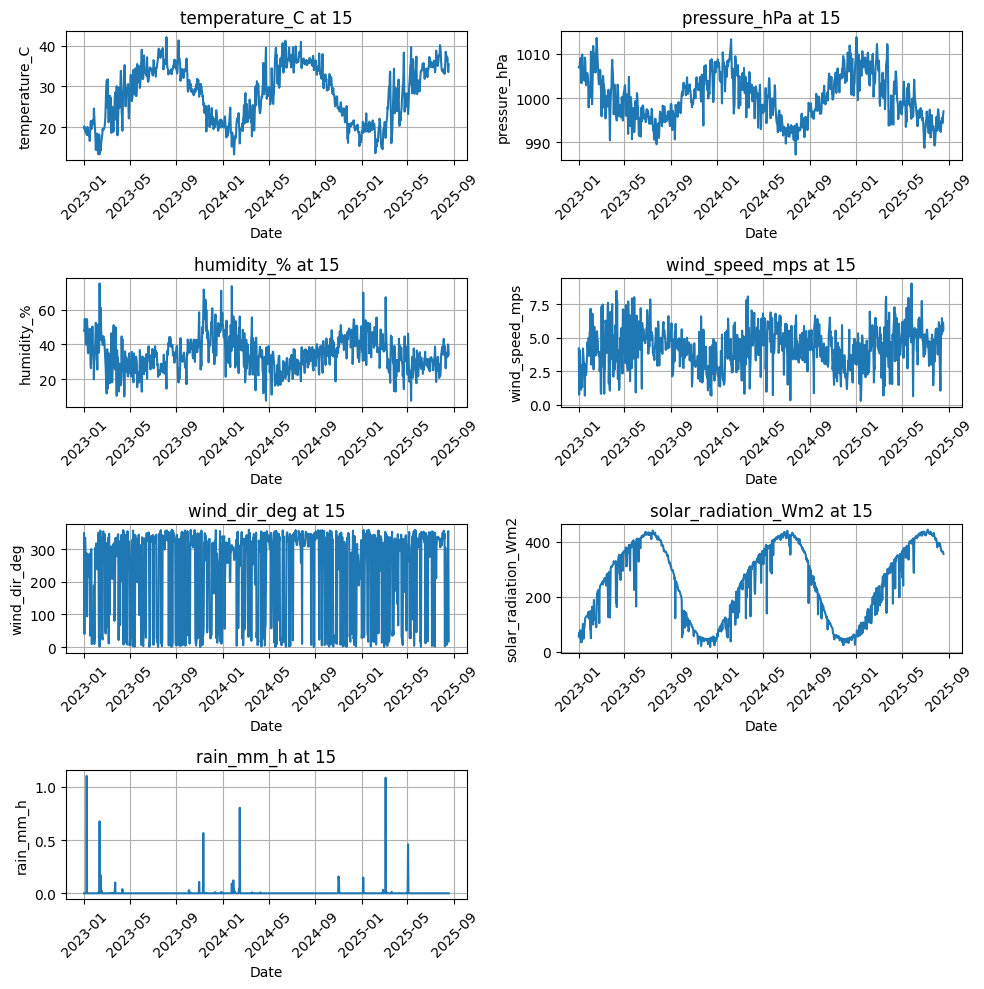

In [27]:
# Graph the features at specific hour each day
target_hour = 15
df_hourly = df[df["hour"] == target_hour]
hourly_values = df_hourly.groupby("date")[weather_cols].mean().reset_index()

plt.figure(figsize=(10, 10))
for i, feat in enumerate(weather_cols, 1):
    plt.subplot(4, 2, i)
    plt.plot(hourly_values["date"], hourly_values[feat])
    plt.title(f"{feat} at {target_hour}")
    plt.xlabel("Date")
    plt.ylabel(feat)
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [28]:
df.columns

Index(['temperature_C', 'pressure_hPa', 'humidity_%', 'wind_speed_mps',
       'wind_dir_deg', 'solar_radiation_Wm2', 'rain_mm_h', 'anomaly', 'hour',
       'month', 'date', 'WeekDay', 'YearDay', 'quarter'],
      dtype='object')

## 2.4 Investigating the features separately

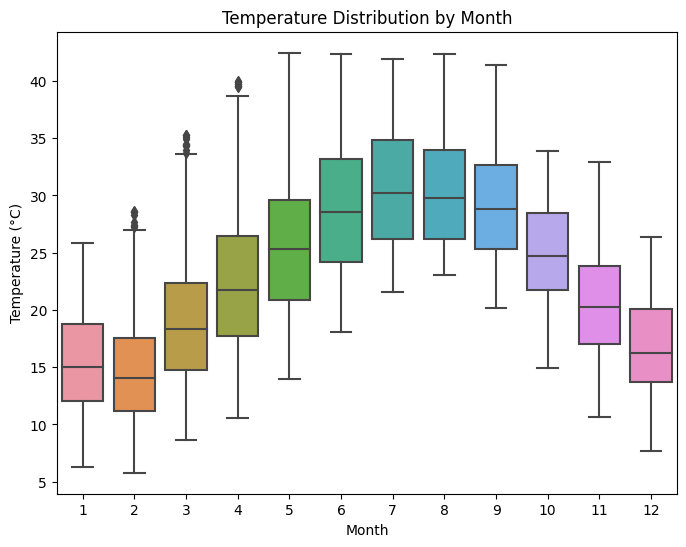

In [29]:
# Temperature Distribution by month
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='month', y='temperature_C')
plt.title('Temperature Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.show()

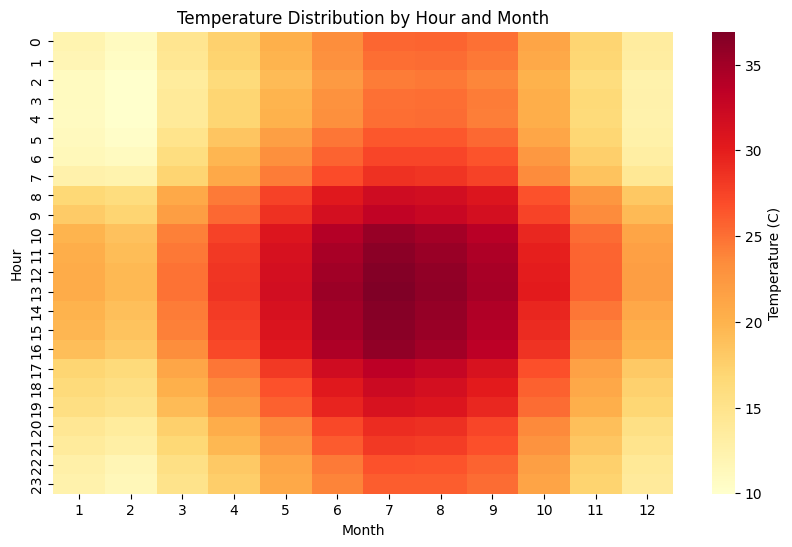

In [30]:
pivot = df.pivot_table(values="temperature_C", index="hour", columns="month", aggfunc="mean")

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="YlOrRd", cbar_kws={'label': 'Temperature (C)'})
plt.title("Temperature Distribution by Hour and Month")
plt.xlabel("Month")
plt.ylabel("Hour")
plt.show()

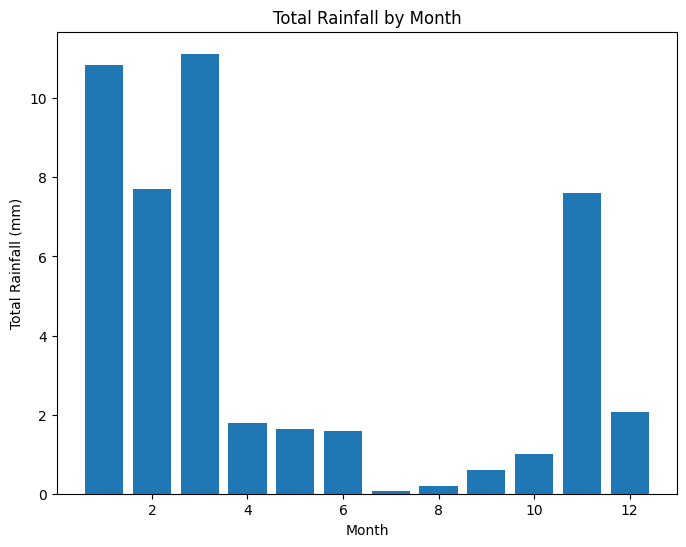

In [31]:
# Total monthly rain
fig = plt.figure(figsize=(8, 6))
monthly_rain = df.groupby('month')['rain_mm_h'].sum()
plt.bar(monthly_rain.index, monthly_rain.values)
plt.title('Total Rainfall by Month')
plt.xlabel('Month')
plt.ylabel('Total Rainfall (mm)')
plt.show()

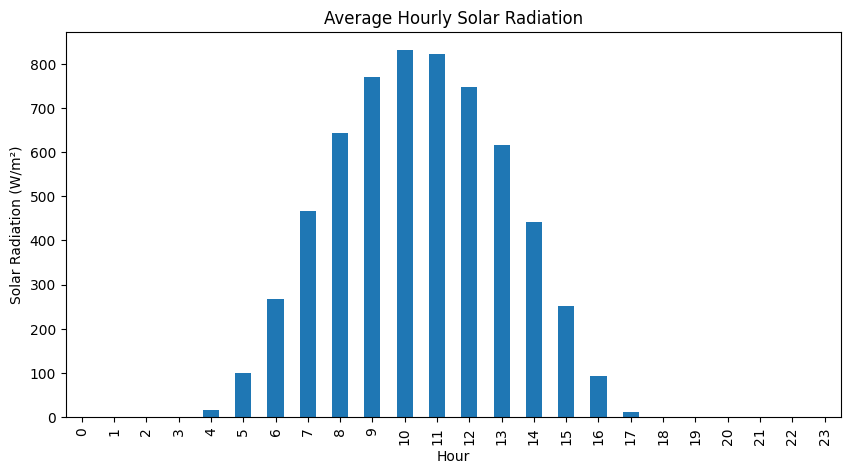

In [32]:
# Solar Radiation Feature
plt.figure(figsize=(10,5))
df.groupby('hour')['solar_radiation_Wm2'].mean().plot(kind='bar')
plt.title("Average Hourly Solar Radiation")
plt.xlabel("Hour")
plt.ylabel("Solar Radiation (W/m²)")
plt.show()

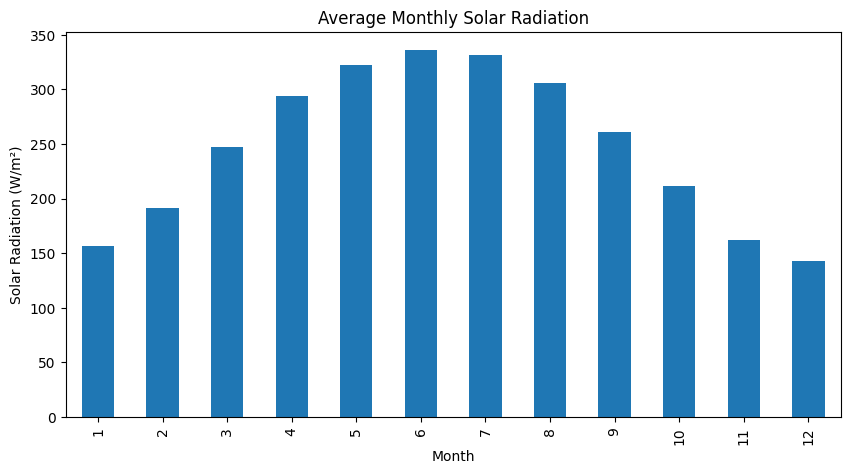

In [33]:
plt.figure(figsize=(10,5))
df.groupby('month')['solar_radiation_Wm2'].mean().plot(kind='bar')
plt.title("Average Monthly Solar Radiation")
plt.xlabel("Month")
plt.ylabel("Solar Radiation (W/m²)")
plt.show()

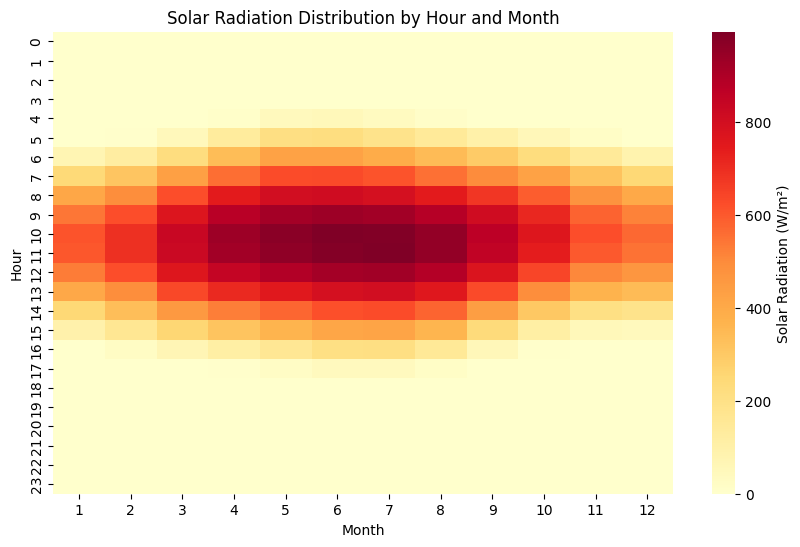

In [34]:
pivot = df.pivot_table(values="solar_radiation_Wm2", index="hour", columns="month", aggfunc="mean")

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="YlOrRd", cbar_kws={'label': 'Solar Radiation (W/m²)'})
plt.title("Solar Radiation Distribution by Hour and Month")
plt.xlabel("Month")
plt.ylabel("Hour")
plt.show()

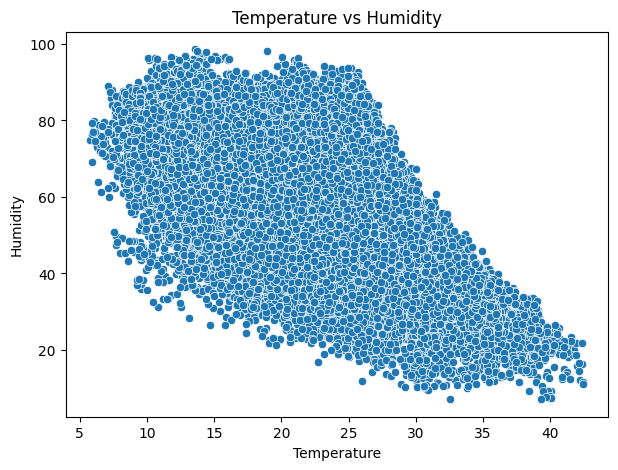

In [35]:
# Relation between temperature & humidity
plt.figure(figsize=(7,5))
sns.scatterplot(x=df['temperature_C'], y=df['humidity_%'])
plt.title("Temperature vs Humidity")
plt.xlabel("Temperature")
plt.ylabel("Humidity")
plt.show()

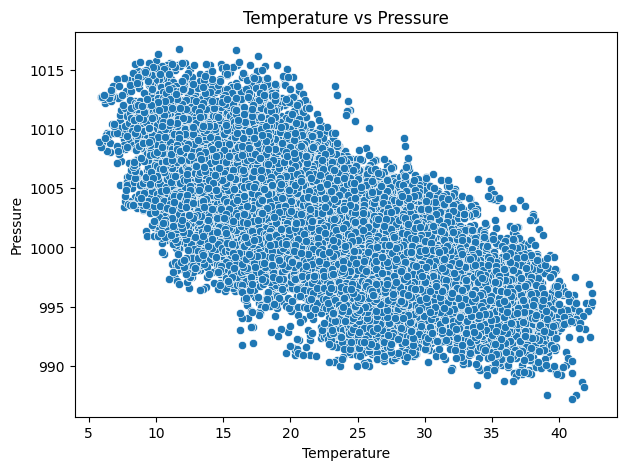

In [36]:
# Relation between temperature & pressure
plt.figure(figsize=(7,5))
sns.scatterplot(x=df['temperature_C'], y=df['pressure_hPa'])
plt.title("Temperature vs Pressure")
plt.xlabel("Temperature")
plt.ylabel("Pressure")
plt.show()

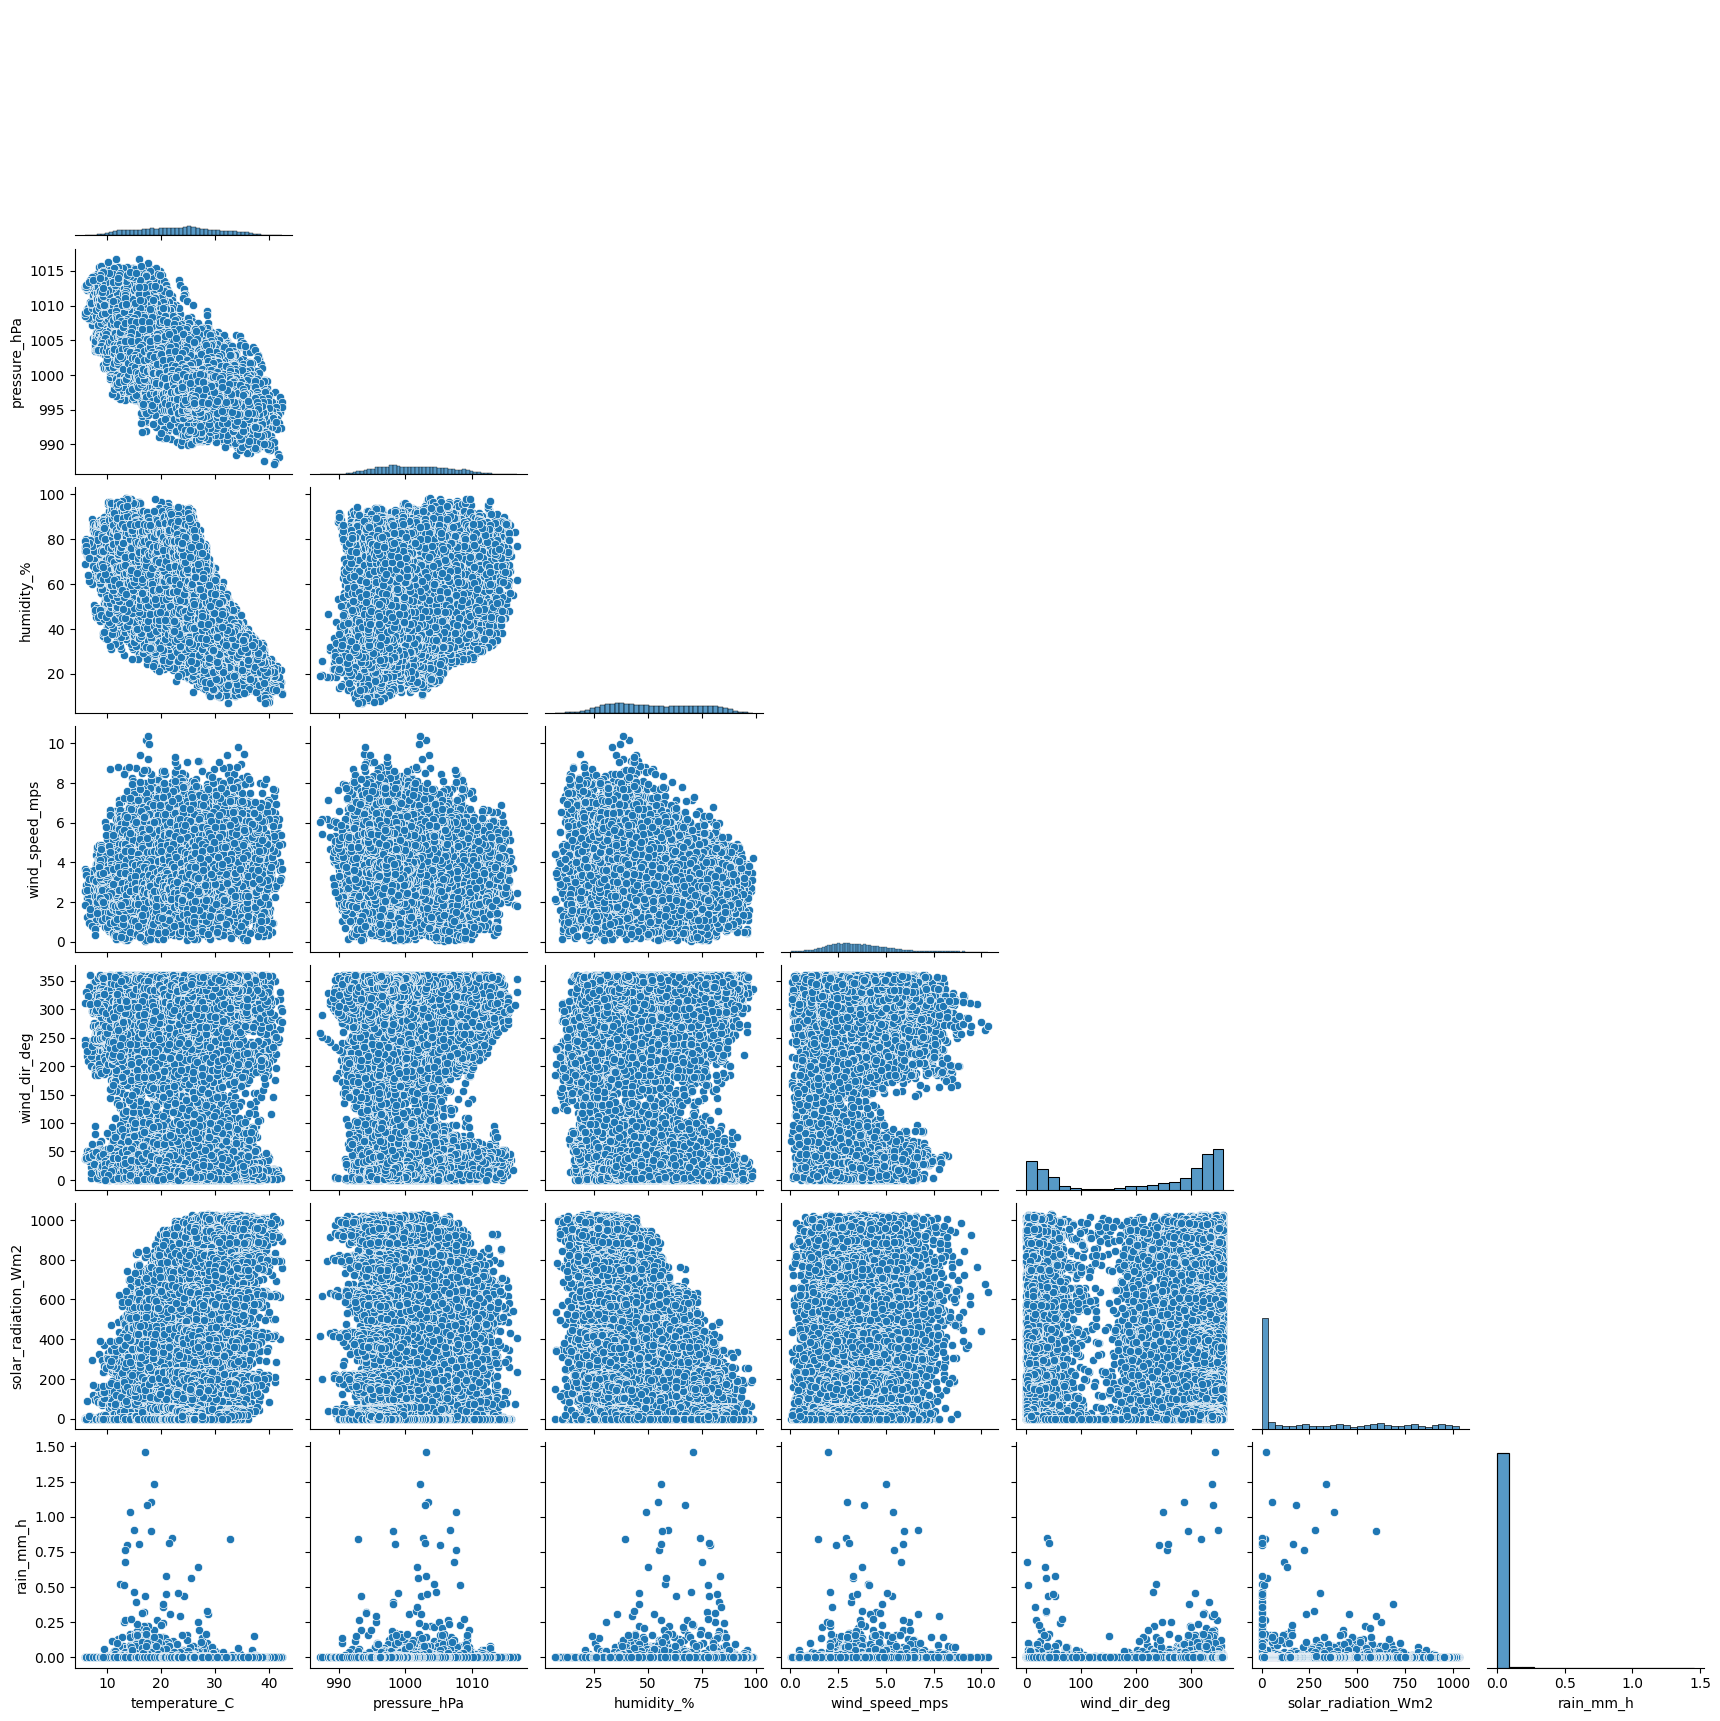

In [37]:
# Draw scatter plot between all features
sns.pairplot(df[weather_cols], corner=True)
plt.show()

In [38]:
# No obvious relationshsips except between temperature & humidity, temperature & pressure

In [39]:
df.columns

Index(['temperature_C', 'pressure_hPa', 'humidity_%', 'wind_speed_mps',
       'wind_dir_deg', 'solar_radiation_Wm2', 'rain_mm_h', 'anomaly', 'hour',
       'month', 'date', 'WeekDay', 'YearDay', 'quarter'],
      dtype='object')

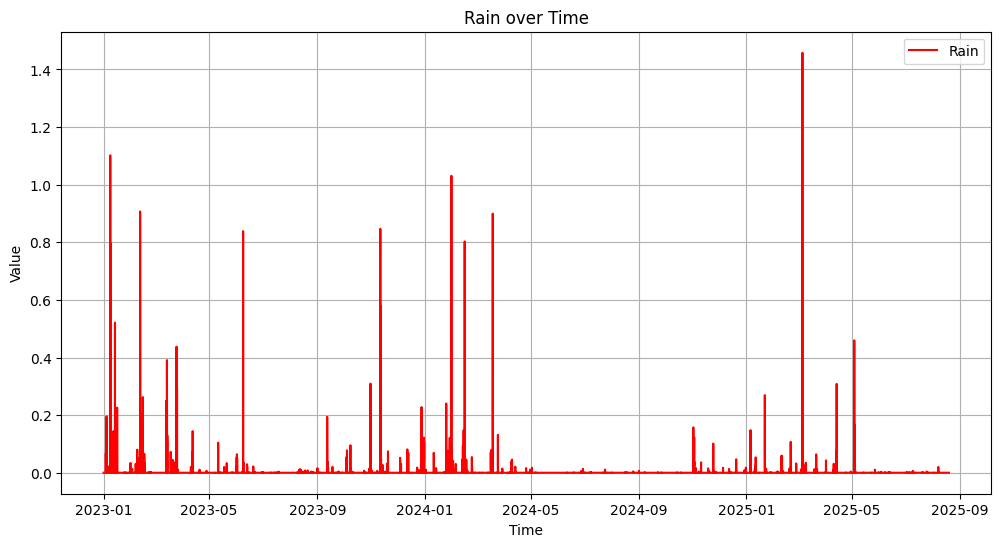

In [40]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['rain_mm_h'], label='Rain', color='red')
# plt.plot(df.index, df['humidity_%'], label='Humidity (%)', color='blue')
plt.title("Rain over Time")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


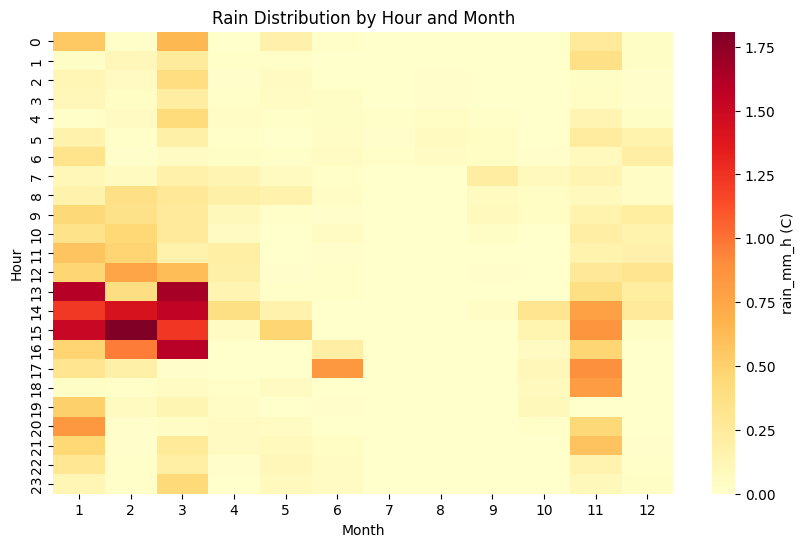

In [41]:
pivot = df.pivot_table(values="rain_mm_h", index="hour", columns="month", aggfunc="sum")

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="YlOrRd", cbar_kws={'label': 'rain_mm_h (C)'})
plt.title("Rain Distribution by Hour and Month")
plt.xlabel("Month")
plt.ylabel("Hour")
plt.show()

## 2.5 Correlation between Features

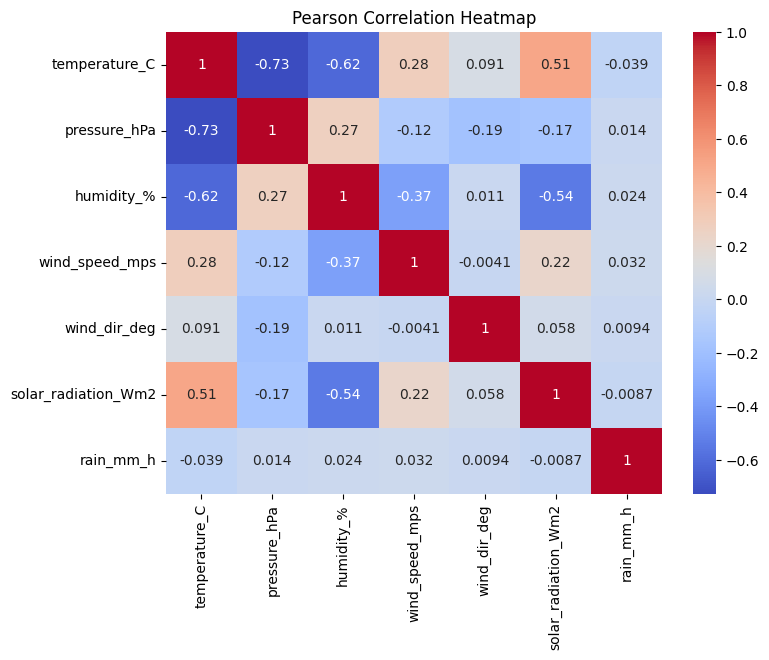

In [42]:
# Pearson Correlation
plt.figure(figsize=(8,6))
sns.heatmap(df[weather_cols].corr(method='pearson'), annot=True, cmap="coolwarm")
plt.title("Pearson Correlation Heatmap")
plt.show()

The solar radiation is highly correlated with the temperature, and negatively correlated with the humidity.
The rain isn't highly correlated with any other feature.
The temperature is negatively correlated with the humidity & the pressure.

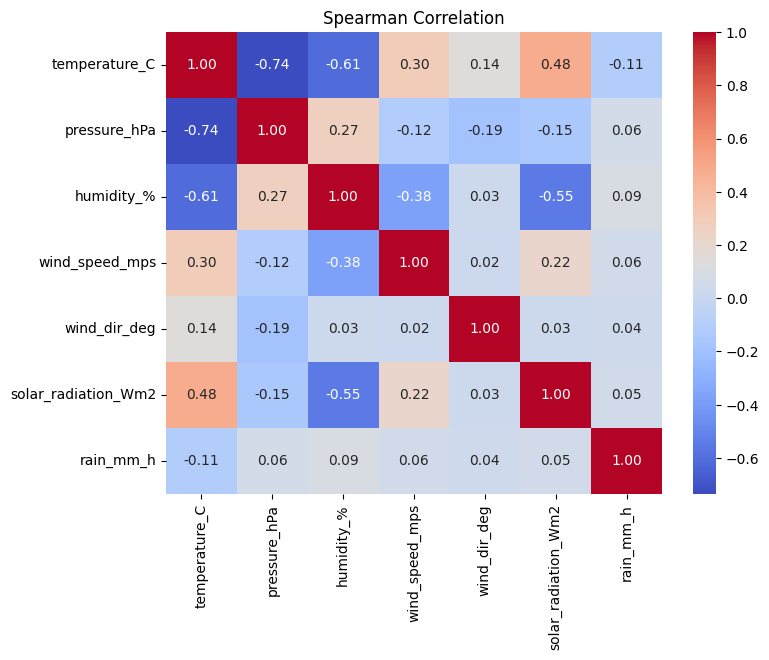

In [43]:
# Spearman Correlation
plt.figure(figsize=(8,6))
spearman = df[weather_cols].corr(method='spearman')
sns.heatmap(spearman, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Spearman Correlation")
plt.show()

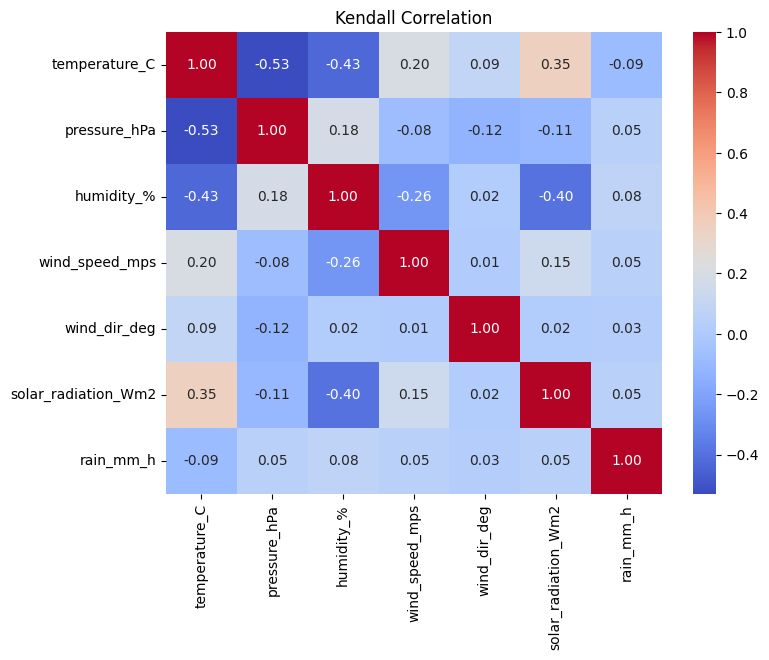

In [44]:
# Kendall Correlation
plt.figure(figsize=(8,6))
kendall  = df[weather_cols].corr(method='kendall')
sns.heatmap(kendall, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Kendall Correlation")
plt.show()

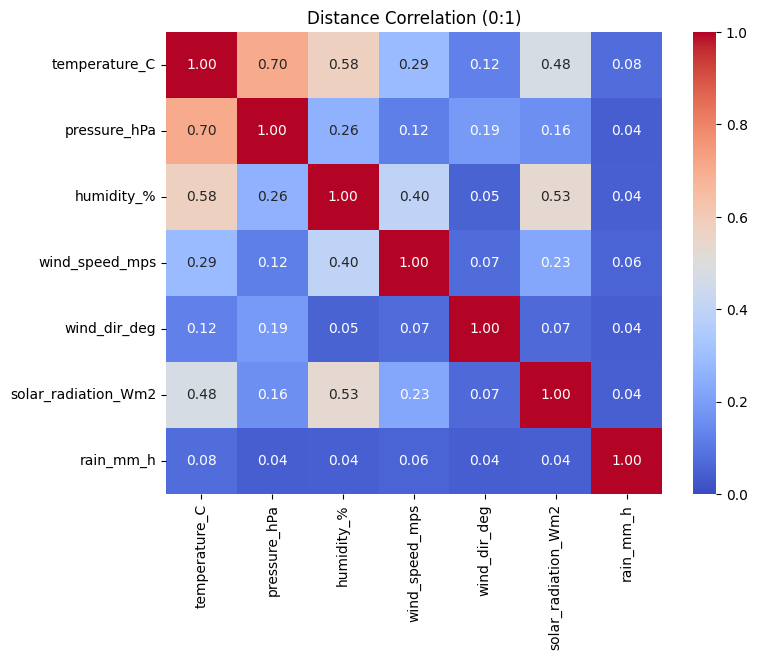

In [45]:
# Distance Correlation
n = len(weather_cols)
dmat = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        dmat[i,j] = dcor.distance_correlation(df[weather_cols[i]].values, df[weather_cols[j]].values)

dcor_df = pd.DataFrame(dmat, index=weather_cols, columns=weather_cols)
plt.figure(figsize=(8,6))
sns.heatmap(dcor_df, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1)
plt.title("Distance Correlation (0:1)")
plt.show()

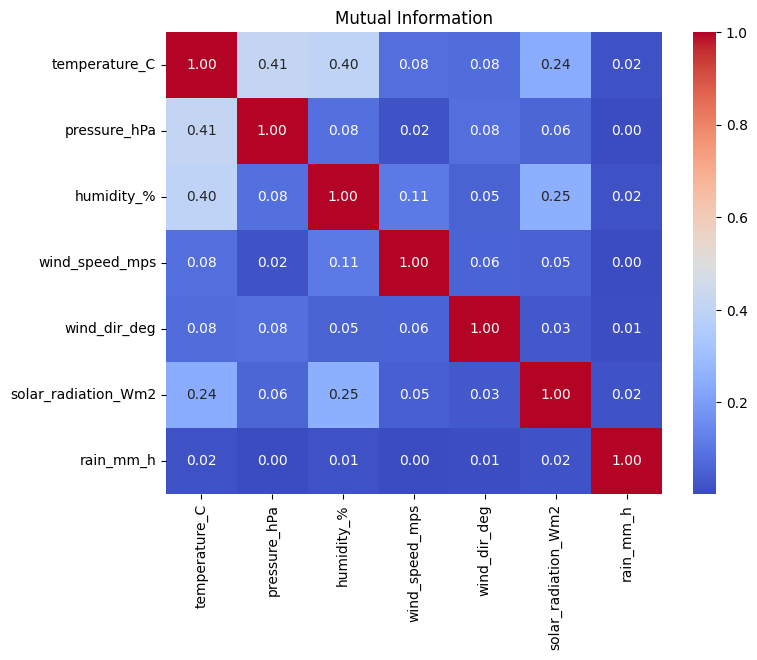

In [46]:
# Mutual Information
mi_scores = np.zeros((len(weather_cols), len(weather_cols)))

for i, col_i in enumerate(weather_cols):
    for j, col_j in enumerate(weather_cols):
        if i == j:
            mi_scores[i, j] = 1.0
        else:
            mi = mutual_info_regression(df[[col_i]], df[col_j], discrete_features=False)
            mi_scores[i, j] = mi[0]

mi_df = pd.DataFrame(mi_scores, index=weather_cols, columns=weather_cols)

plt.figure(figsize=(8,6))
sns.heatmap(mi_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mutual Information')
plt.show()

# 3. Data Preprocessing

In [47]:
# Drop 'hour', 'month', 'date' columns
# df.drop(columns=['hour', 'month', 'date'], inplace=True)
# No need to drop them. They actually may be indication for the prediction, need to be part of x

In [48]:
df.head()

temperature_C  pressure_hPa  humidity_%  wind_speed_mps  \
valid_time                                                                     
2023-01-01 00:00:00      12.756500    1010.58124   79.738754        3.468907   
2023-01-01 01:00:00      12.593414    1010.27185   80.456370        3.658261   
2023-01-01 02:00:00      11.921295    1009.95874   79.984800        3.759195   
2023-01-01 03:00:00      11.582428    1009.84750   80.606670        3.705409   
2023-01-01 04:00:00      12.017487    1010.04315   78.757800        3.655312   

                     wind_dir_deg  solar_radiation_Wm2  rain_mm_h  anomaly  \
valid_time                                                                   
2023-01-01 00:00:00     357.04996                  0.0        0.0        0   
2023-01-01 01:00:00     353.96478                  0.0        0.0        0   
2023-01-01 02:00:00     352.78160                  0.0        0.0        0   
2023-01-01 03:00:00     352.17070                  0.0        0.0        0   
2023-01-01 04:00:00     352.34924                  0.0        0.0        0   

                     hour  month        date  WeekDay  YearDay  quarter  
valid_time                                                               
2023-01-01 00:00:00     0      1  2023-01-01        6        1        1  
2023-01-01 01:00:00     1      1  2023-01-01        6        1        1  
2023-01-01 02:00:00     2      1  2023-01-01        6        1        1  
2023-01-01 03:00:00     3      1  2023-01-01        6        1        1  
2023-01-01 04:00:00     4      1  2023-01-01        6        1        1

In [49]:
df.drop(columns=['date'], inplace=True)
df.head()

temperature_C  pressure_hPa  humidity_%  wind_speed_mps  \
valid_time                                                                     
2023-01-01 00:00:00      12.756500    1010.58124   79.738754        3.468907   
2023-01-01 01:00:00      12.593414    1010.27185   80.456370        3.658261   
2023-01-01 02:00:00      11.921295    1009.95874   79.984800        3.759195   
2023-01-01 03:00:00      11.582428    1009.84750   80.606670        3.705409   
2023-01-01 04:00:00      12.017487    1010.04315   78.757800        3.655312   

                     wind_dir_deg  solar_radiation_Wm2  rain_mm_h  anomaly  \
valid_time                                                                   
2023-01-01 00:00:00     357.04996                  0.0        0.0        0   
2023-01-01 01:00:00     353.96478                  0.0        0.0        0   
2023-01-01 02:00:00     352.78160                  0.0        0.0        0   
2023-01-01 03:00:00     352.17070                  0.0        0.0        0   
2023-01-01 04:00:00     352.34924                  0.0        0.0        0   

                     hour  month  WeekDay  YearDay  quarter  
valid_time                                                   
2023-01-01 00:00:00     0      1        6        1        1  
2023-01-01 01:00:00     1      1        6        1        1  
2023-01-01 02:00:00     2      1        6        1        1  
2023-01-01 03:00:00     3      1        6        1        1  
2023-01-01 04:00:00     4      1        6        1        1

In [50]:
df.iloc[:,0:7]

temperature_C  pressure_hPa  humidity_%  wind_speed_mps  \
valid_time                                                                     
2023-01-01 00:00:00      12.756500    1010.58124   79.738754        3.468907   
2023-01-01 01:00:00      12.593414    1010.27185   80.456370        3.658261   
2023-01-01 02:00:00      11.921295    1009.95874   79.984800        3.759195   
2023-01-01 03:00:00      11.582428    1009.84750   80.606670        3.705409   
2023-01-01 04:00:00      12.017487    1010.04315   78.757800        3.655312   
...                            ...           ...         ...             ...   
2025-08-19 04:00:00      27.618805     996.07935   45.536247        0.533070   
2025-08-19 05:00:00      28.734772     996.02814   42.259365        0.414886   
2025-08-19 06:00:00      30.402740     996.30130   36.438580        0.485815   
2025-08-19 07:00:00      31.997711     996.13120   32.664364        0.904579   
2025-08-19 08:00:00      36.095367     996.22186   26.093924        1.318635   

                     wind_dir_deg  solar_radiation_Wm2  rain_mm_h  
valid_time                                                         
2023-01-01 00:00:00    357.049960             0.000000        0.0  
2023-01-01 01:00:00    353.964780             0.000000        0.0  
2023-01-01 02:00:00    352.781600             0.000000        0.0  
2023-01-01 03:00:00    352.170700             0.000000        0.0  
2023-01-01 04:00:00    352.349240             0.000000        0.0  
...                           ...                  ...        ...  
2025-08-19 04:00:00    184.873550            12.266666        0.0  
2025-08-19 05:00:00    152.219180           146.400000        0.0  
2025-08-19 06:00:00     91.391205           357.084440        0.0  
2025-08-19 07:00:00     67.851500           569.244450        0.0  
2025-08-19 08:00:00     42.371370           749.155600        0.0  

[23073 rows x 7 columns]

In [51]:
df.shape

(23073, 13)

In [52]:
# Train test split
train_size = int(len(df)*0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [53]:
train_df.shape

(18458, 13)

In [54]:
test_df.head()

temperature_C  pressure_hPa  humidity_%  wind_speed_mps  \
valid_time                                                                     
2025-02-08 02:00:00      10.212555     1009.2625   67.780790        2.948911   
2025-02-08 03:00:00      10.570953     1009.4981   70.376570        2.833264   
2025-02-08 04:00:00      10.357330     1009.8425   71.830956        2.643198   
2025-02-08 05:00:00      10.122223     1010.3656   73.300514        2.340327   
2025-02-08 06:00:00      10.562164     1010.4369   70.409430        2.314418   

                     wind_dir_deg  solar_radiation_Wm2  rain_mm_h  anomaly  \
valid_time                                                                   
2025-02-08 02:00:00     318.43738             0.000000        0.0        0   
2025-02-08 03:00:00     323.81305             0.000000        0.0        0   
2025-02-08 04:00:00     327.02954             0.000000        0.0        0   
2025-02-08 05:00:00     328.44766             2.382222        0.0        0   
2025-02-08 06:00:00     331.90085           102.417780        0.0        0   

                     hour  month  WeekDay  YearDay  quarter  
valid_time                                                   
2025-02-08 02:00:00     2      2        5       39        1  
2025-02-08 03:00:00     3      2        5       39        1  
2025-02-08 04:00:00     4      2        5       39        1  
2025-02-08 05:00:00     5      2        5       39        1  
2025-02-08 06:00:00     6      2        5       39        1

## 3.1 Sliding Windows

In [55]:
# Creating Sliding Window
def create_sliding_window(data, window_size=20, forecast_steps=10):
    '''
    This function create the sliding window to make it seq2seq.
    They are overlapping sliding windows with a stride of 1.
    It takes the data, the window size, and the steps to forecast
    '''
    x,y = [], []
    
    for i in range(len(data) - window_size - forecast_steps):
        # get x & y for each sliding window
        x.append(data.iloc[i : i+window_size, :].values)
        y.append(data.iloc[i+window_size : i+window_size+forecast_steps, 0:7].values)
        # x: all features + engineered, y: only 7 weather features
        # columns 0:7 are the 7 weather features
    return np.array(x), np.array(y)

In [56]:
# These values will be used later in the model
window_size=20
forecast_steps=10

In [57]:
x_train_notScaled, y_train_notScaled = create_sliding_window(train_df, window_size, forecast_steps)
x_test_notScaled, y_test_notScaled = create_sliding_window(test_df, window_size, forecast_steps)

We have a problem here about scaling. We need 2 separate scalers for x & y as they are different in the second dimension.

x --> 13 features (7 weather features + Engineered ones)

y --> only the 7 weather features



And MinMax scaler accepts only till 2D, so the plan is
* use scaler_x for inputs (13 features)
* use scaler_y for targets (7 features)
* always reshape to 2D before scaling, reshape back to 3D after

In [58]:
x_train_notScaled.shape, y_train_notScaled.shape, x_test_notScaled.shape, y_test_notScaled.shape

((18428, 20, 13), (18428, 10, 7), (4585, 20, 13), (4585, 10, 7))

## 3.2 Scaling

In [59]:
# Data Normalization - X (all features)
scaler_x = MinMaxScaler()

# Reshape first from 3d to 3d
x_train_2d = x_train_notScaled.reshape(-1, x_train_notScaled.shape[2])
x_test_2d  = x_test_notScaled.reshape(-1, x_test_notScaled.shape[2])

x_train = scaler_x.fit_transform(x_train_2d).reshape(x_train_notScaled.shape)
x_test  = scaler_x.transform(x_test_2d).reshape(x_test_notScaled.shape)

In [60]:
# Data Normalization - Y (Only 7 features)
scaler_y = MinMaxScaler()

# Reshape first from 3d to 3d
y_train_2d = y_train_notScaled.reshape(-1, y_train_notScaled.shape[2])
y_test_2d  = y_test_notScaled.reshape(-1, y_test_notScaled.shape[2])

y_train = scaler_y.fit_transform(y_train_2d).reshape(y_train_notScaled.shape)
y_test  = scaler_y.transform(y_test_2d).reshape(y_test_notScaled.shape)

In [61]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# no of samples, no of records, features
# train_records = 20 --> window size
# test_records = 10 --> forecast steps

((18428, 20, 13), (18428, 10, 7), (4585, 20, 13), (4585, 10, 7))

# 4. Building the Model

We use three metrics to evalute our models. Below are the used metrics and what each one indicates.

Metric: Definition

**Mean Absolute Error**: MAE of 1.8°C means temperature forecasts are off by about 1.8 degrees on average.

**Mean Absolute Percentage Error**: MAPE of 8% means humidity forecasts miss by about 8% of the true humidity level.

**Root Mean Square Error**: penalizes large errors more, it's sensitive to big mistakes

**Coefficient of Determination (R2 Score)**: It shows how well predictions capture the variability in data, with a value between 0 and 1. R2 of 0.8 means the model explains 80% of the variability in this feature.

## Baseline Model

In [62]:
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(window_size,x_train.shape[2])))
# model.add(GRU(64, activation='tanh', input_shape=(window_size,x_train.shape[2])))
# model.add(SimpleRNN(64, activation='tanh', input_shape=(window_size,x_train.shape[2])))
# input_shape=(window_size, no of features)
model.add(Dense(forecast_steps * y_train.shape[2]))
# flatten output for the forecast steps * features

I0000 00:00:1758629783.991961     104 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [63]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 70)             │         4,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,518 (95.77 KB)

 Trainable params: 24,518 (95.77 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [65]:
history = model.fit(x_train, y_train.reshape(y_train.shape[0], -1),
                    epochs = 200, batch_size = 32, validation_split=0.1,
                   callbacks = [early_stopping], verbose=1)

Epoch 1/200


I0000 00:00:1758629793.052602     154 cuda_dnn.cc:529] Loaded cuDNN version 90300


519/519 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0524 - val_loss: 0.0193
Epoch 2/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0175 - val_loss: 0.0161
Epoch 3/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0159 - val_loss: 0.0153
Epoch 4/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0153 - val_loss: 0.0150
Epoch 5/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 6/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0146 - val_loss: 0.0146
Epoch 7/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 8/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 9/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0139 - val_loss: 0.0141
Epoch 10/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 11/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0136 - val_loss: 0.0140
Epoch 12/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

In [66]:
y_pred = model.predict(x_test)
# print(y_pred.shape)
y_pred = y_pred.reshape(y_test.shape)
# from (no of samples, steps*features) --> (no of samples, steps, features)
# print(y_pred.shape)

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [67]:
y_test.shape, y_pred.shape

((4585, 10, 7), (4585, 10, 7))

In [70]:
# # Y-Inverse transform
# y_pred_2d = y_pred.reshape(-1, y_pred.shape[2])
# # from (no of samples, steps, features) --> (no of samples*steps, features)

# # y_pred_rescaled = scaler_y.inverse_transform(y_pred_2d).reshape(y_pred.shape)
# # y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[2])).reshape(y_test.shape)

# y_pred_rescaled_2d = scaler_y.inverse_transform(y_pred_2d)
# y_pred_rescaled = y_pred_rescaled_2d.reshape(y_pred.shape)
# y_test_rescaled_2d = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[2]))
# y_test_rescaled = y_test_rescaled_2d.reshape(y_test.shape)
# # from (no of samples*steps, features) --> (no of samples, steps, features)

In [68]:
# Y-Inverse transform
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[2]))
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[2]))

In [69]:
y_test_rescaled.shape, y_pred_rescaled.shape

((45850, 7), (45850, 7))

In [70]:
y_test.shape, y_pred.shape

((4585, 10, 7), (4585, 10, 7))

In [71]:
y_test2 = y_test.reshape(-1,7)
y_pred2 = y_pred.reshape(-1, 7)

In [76]:
mae_overall = mean_absolute_error(y_test2, y_pred2)
# mape_overall = mean_absolute_percentage_error(y_test2, y_pred2) * 100
rmse_overall = np.sqrt(mean_squared_error(y_test2, y_pred2))
r2 = r2_score(y_test2, y_pred2)
print(f"Overall -> R2Score: {r2:.4f}, MAE: {mae_overall:.4f}, RMSE: {rmse_overall:.4f}")

Overall -> R2Score: 0.6884, MAE: 0.0573, RMSE: 0.1170


In [77]:
mae_overall = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
# mape_overall = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled) * 100
rmse_overall = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"Overall -> R2Score: {r2:.4f}, MAE: {mae_overall:.4f}, RMSE: {rmse_overall:.4f}")

Overall -> R2Score: 0.6884, MAE: 15.9964, RMSE: 42.9981


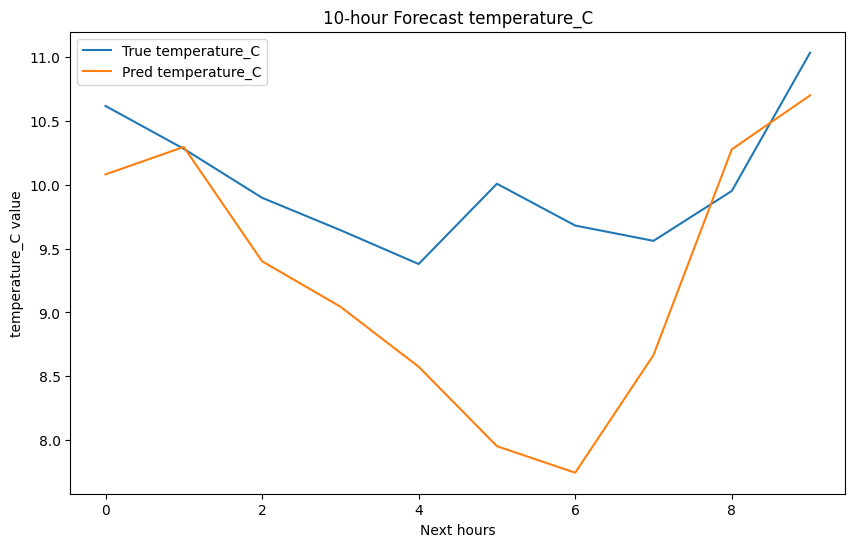

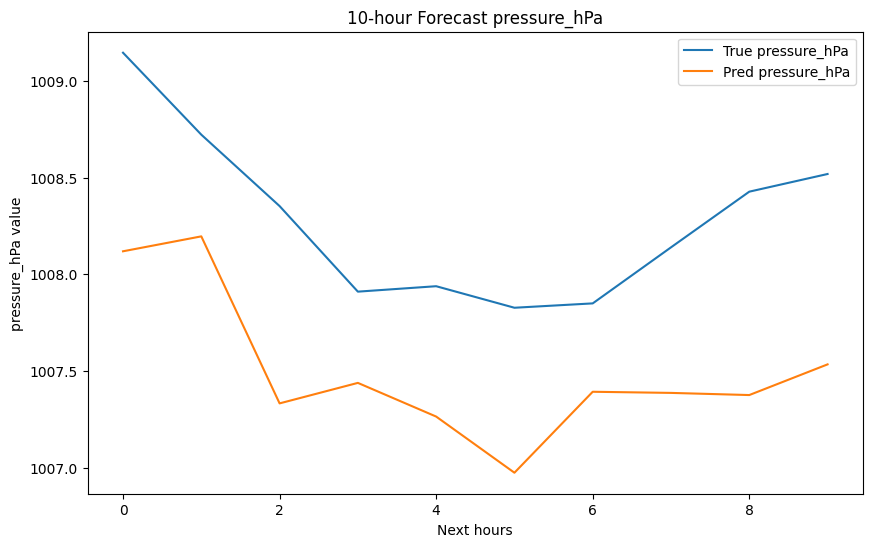

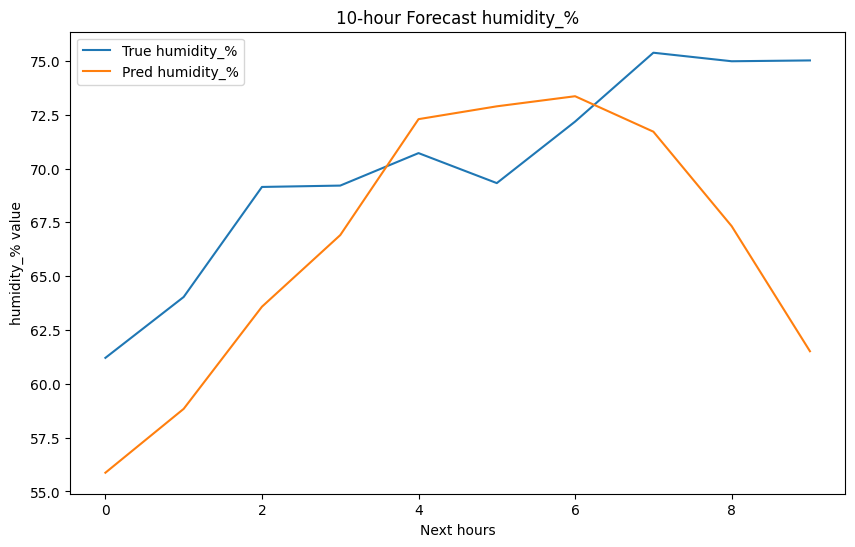

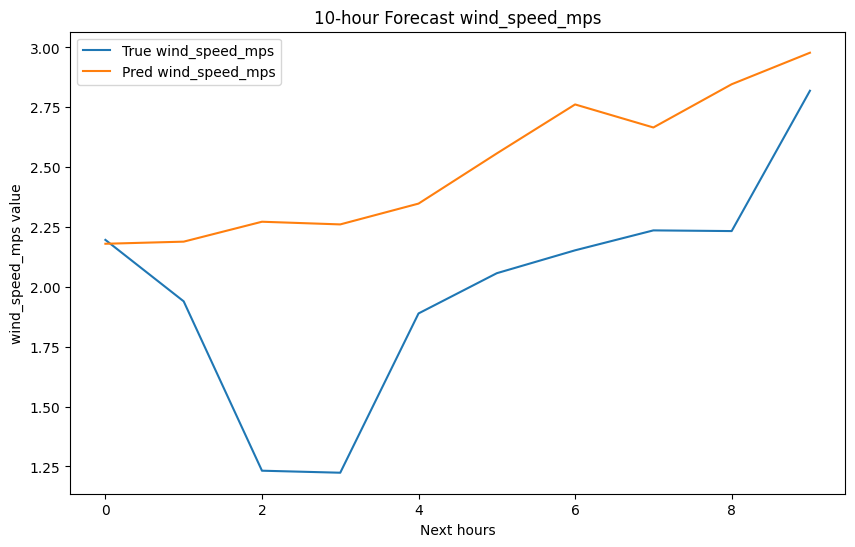

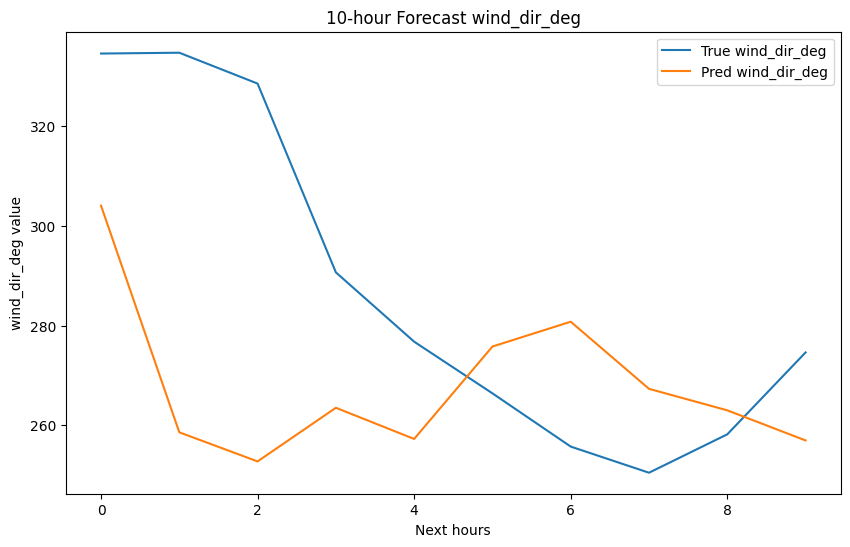

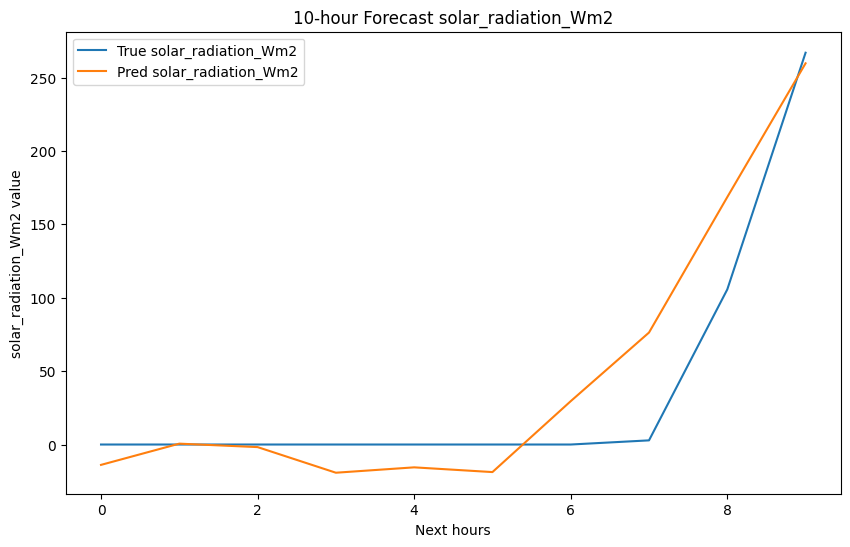

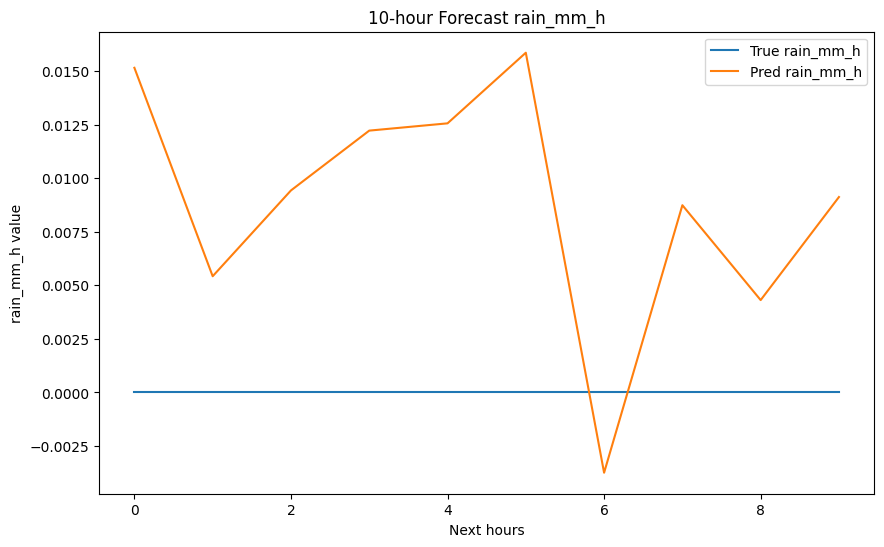

In [79]:
for i,feature in enumerate(weather_cols):
    plt.figure(figsize=(10,6))
    plt.plot(y_test_rescaled[:10, i], label=f"True {feature}")
    plt.plot(y_pred_rescaled[:10, i], label=f"Pred {feature}")
    plt.xlabel('Next hours')
    plt.ylabel(f'{feature} value')
    plt.title(f"10-hour Forecast {feature}")
    plt.legend()
    plt.show()

## 2nd Model

In [80]:
# More Dense LSTM model

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(window_size,x_train.shape[2]), return_sequences=False))
model.add(RepeatVector(forecast_steps))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(y_train.shape[2])))

In [81]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 7)          │           455 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,447 (208.78 KB)

 Trainable params: 53,447 (208.78 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# Callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [83]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((18428, 20, 13), (18428, 10, 7), (4585, 20, 13), (4585, 10, 7))

In [84]:
history = model.fit(x_train, y_train,
                    epochs = 200, batch_size = 32, validation_split=0.1,
                   callbacks = [early_stopping], verbose=1)

Epoch 1/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0433 - val_loss: 0.0176
Epoch 2/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0172 - val_loss: 0.0160
Epoch 3/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 4/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0149 - val_loss: 0.0155
Epoch 5/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0144 - val_loss: 0.0152
Epoch 6/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0141 - val_loss: 0.0150
Epoch 7/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0138 - val_loss: 0.0148
Epoch 8/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0135 - val_loss: 0.0147
Epoch 9/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0132 - val_loss: 0.0147
Epoch 10/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0130 - val_loss: 0.0149
Epoch 11/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0128 - val_loss: 0.0152
Epoch 12/200
519/519 ━━━━━━━━━━━━━━━━━━━━

In [85]:
y_pred = model.predict(x_test)
y_pred = y_pred.reshape(y_test.shape)

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [86]:
# Y-Inverse transform
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[2]))
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[2]))

In [87]:
mae_overall = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
# mape_overall = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled) * 100
rmse_overall = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"Overall -> R2Score: {r2:.4f}, MAE: {mae_overall:.4f}, RMSE: {rmse_overall:.4f}")

Overall -> R2Score: 0.6783, MAE: 16.0247, RMSE: 43.2054


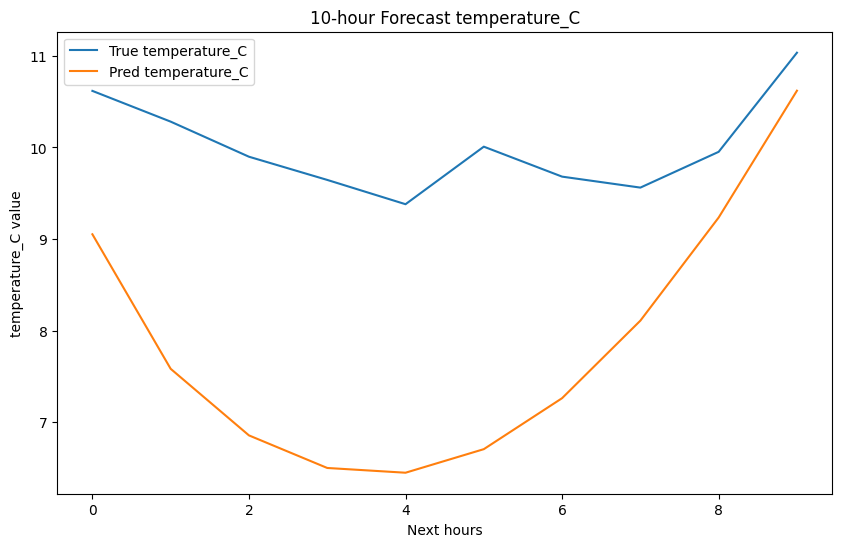

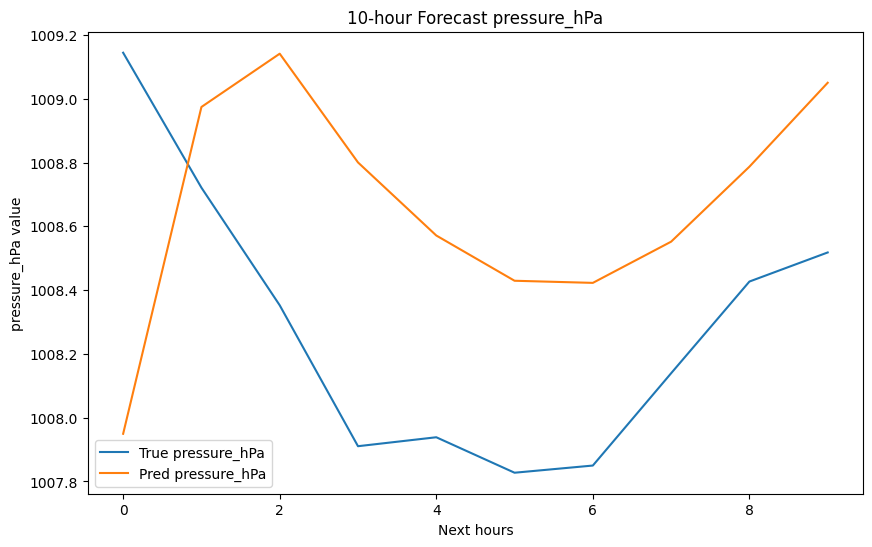

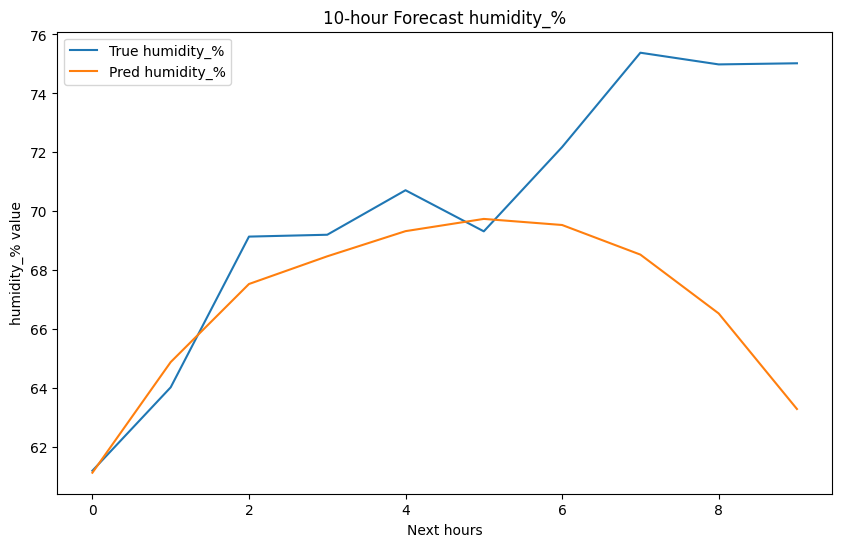

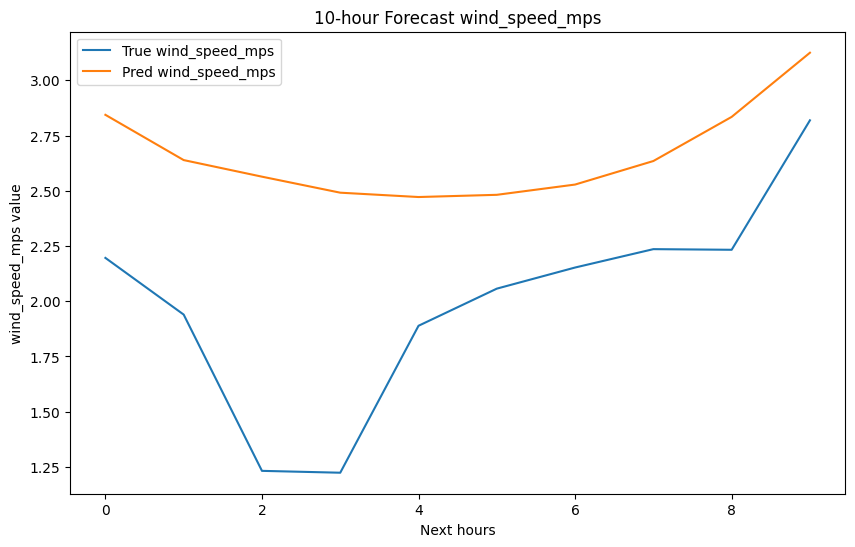

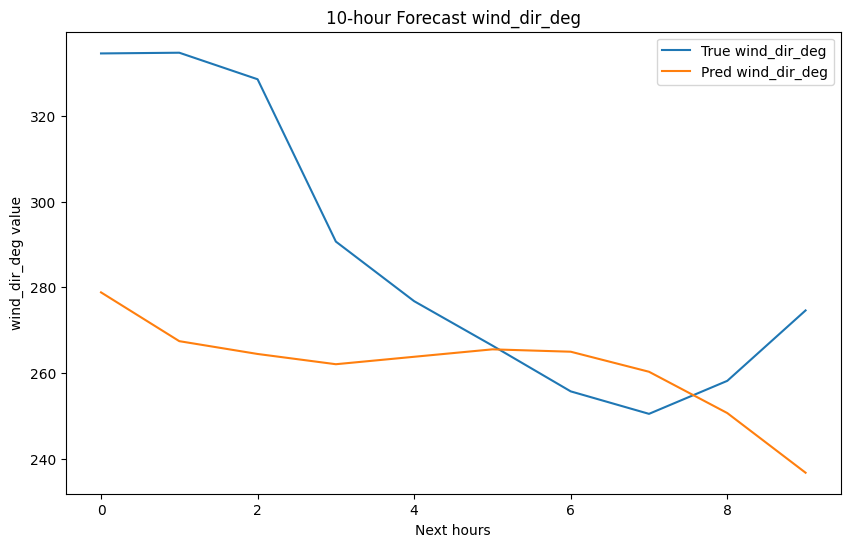

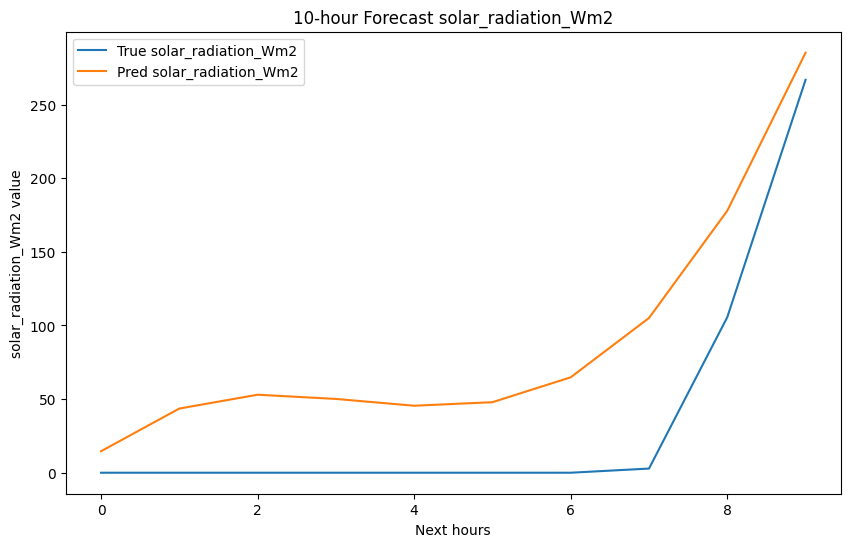

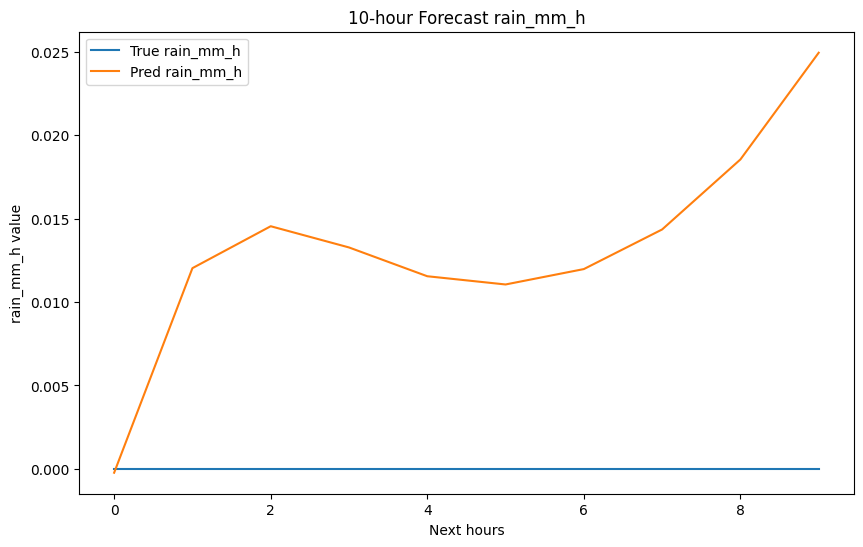

In [88]:
for i,feature in enumerate(weather_cols):
    plt.figure(figsize=(10,6))
    plt.plot(y_test_rescaled[:10,i], label=f"True {feature}")
    plt.plot(y_pred_rescaled[:10,i], label=f"Pred {feature}")
    plt.xlabel('Next hours')
    plt.ylabel(f'{feature} value')
    plt.title(f"10-hour Forecast {feature}")
    plt.legend()
    plt.show()

## 3rd Model

In [89]:
# CNN + LSTM

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size,x_train.shape[2])))
model.add(MaxPooling1D(pool_size=2)),
model.add(LSTM(64))
model.add(RepeatVector(forecast_steps))
model.add(LSTM(64, return_sequences=True))
model.add(TimeDistributed(Dense(y_train.shape[2])))

In [90]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 18, 32)         │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 7)          │           455 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,591 (232.78 KB)

 Trainable params: 59,591 (232.78 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [92]:
history = model.fit(x_train, y_train,
                    epochs = 200, batch_size = 32, validation_split=0.1,
                   callbacks = [early_stopping], verbose=1)

Epoch 1/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0441 - val_loss: 0.0188
Epoch 2/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0178 - val_loss: 0.0168
Epoch 3/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0163 - val_loss: 0.0158
Epoch 4/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 5/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0149 - val_loss: 0.0150
Epoch 6/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0144 - val_loss: 0.0148
Epoch 7/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0141 - val_loss: 0.0147
Epoch 8/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0138 - val_loss: 0.0147
Epoch 9/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0135 - val_loss: 0.0147
Epoch 10/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0132 - val_loss: 0.0147
Epoch 11/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0129 - val_loss: 0.0149
Epoch 12/200
519/519 ━━━━━━━━━━━━━━━━━━━━

In [93]:
y_pred = model.predict(x_test)
y_pred = y_pred.reshape(y_test.shape)

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [94]:
# Y-Inverse transform
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[2]))
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[2]))

In [95]:
mae_overall = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
# mape_overall = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled) * 100
rmse_overall = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"Overall -> R2Score: {r2:.4f}, MAE: {mae_overall:.4f}, RMSE: {rmse_overall:.4f}")

Overall -> R2Score: 0.6636, MAE: 16.3355, RMSE: 44.1443


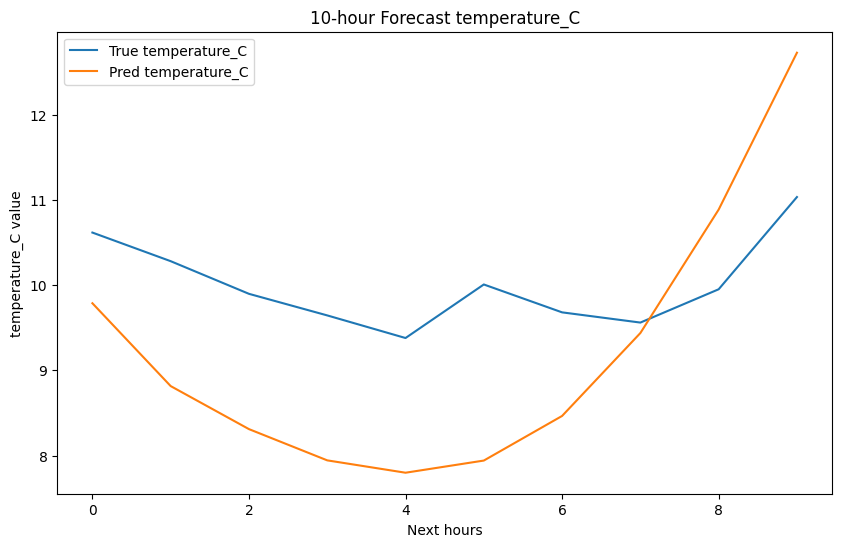

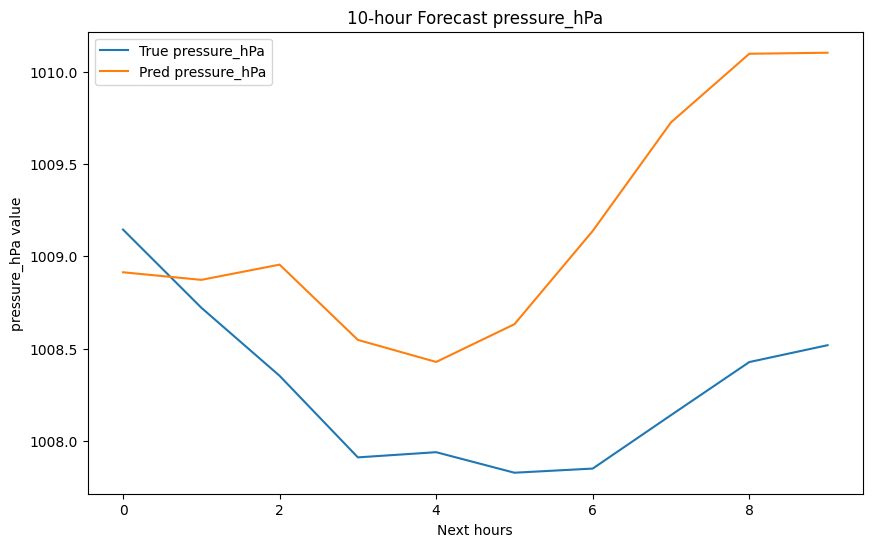

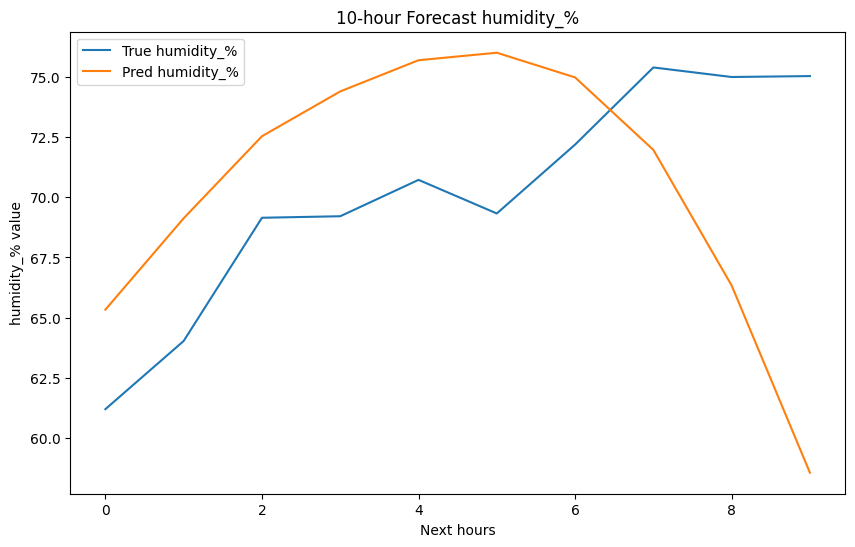

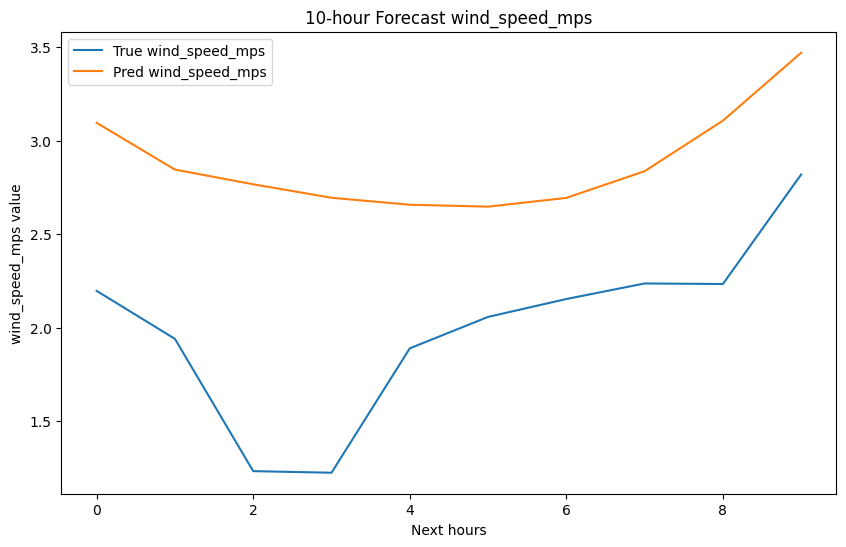

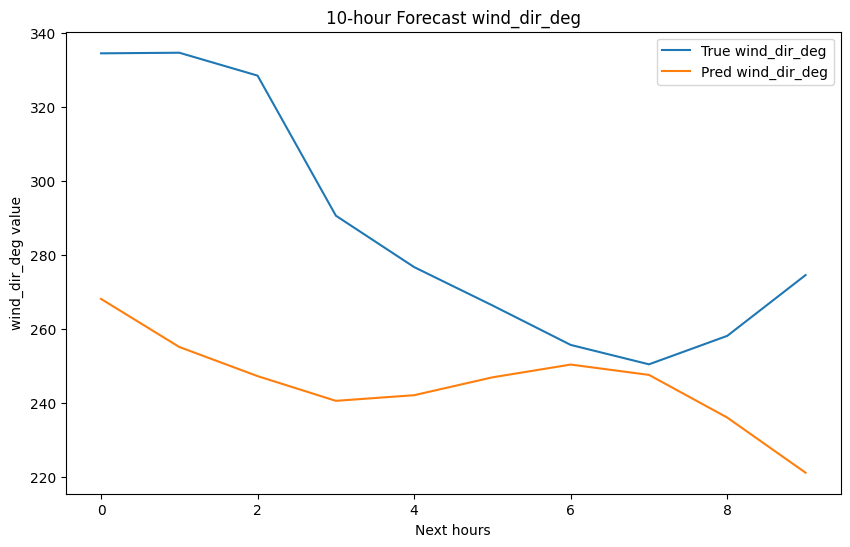

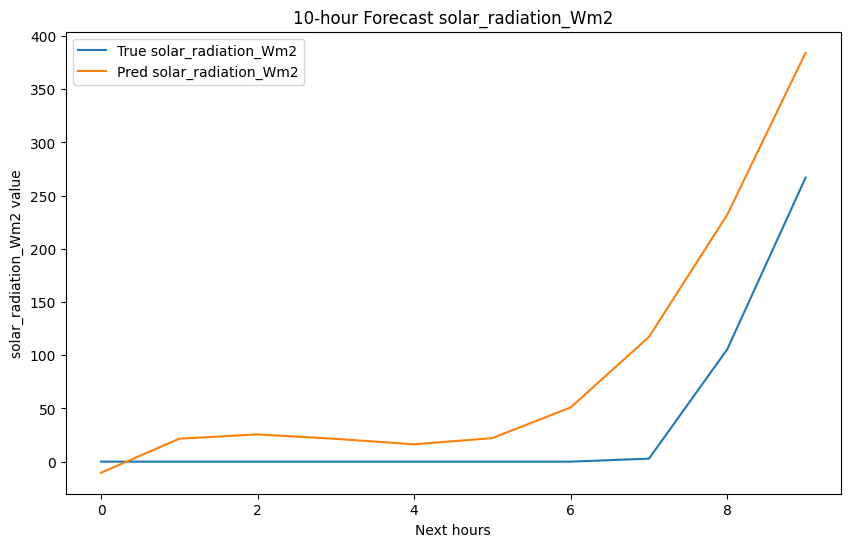

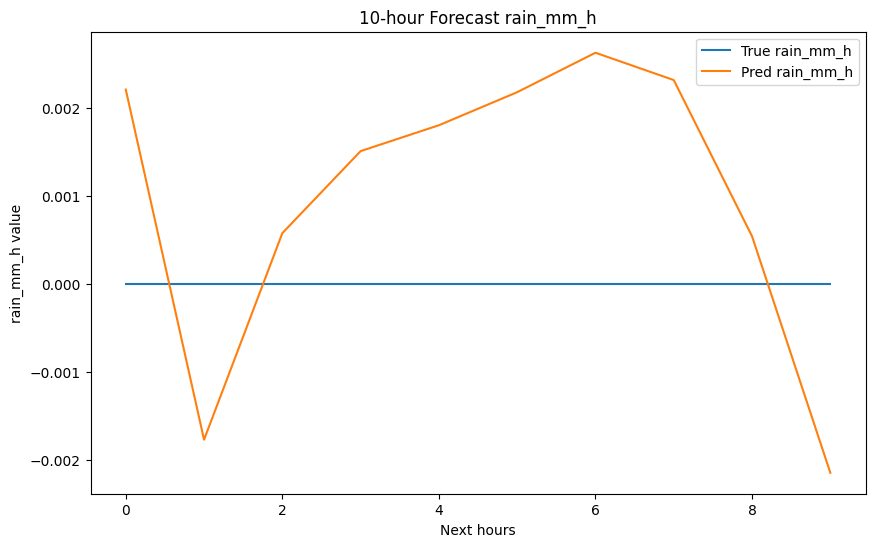

In [96]:
for i,feature in enumerate(weather_cols):
    plt.figure(figsize=(10,6))
    plt.plot(y_test_rescaled[:10,i], label=f"True {feature}")
    plt.plot(y_pred_rescaled[:10,i], label=f"Pred {feature}")
    plt.xlabel('Next hours')
    plt.ylabel(f'{feature} value')
    plt.title(f"10-hour Forecast {feature}")
    plt.legend()
    plt.show()

## Ensemble Models

In [116]:
x_train_notScaled.shape, y_train_notScaled.shape, x_test_notScaled.shape, y_test_notScaled.shape

((18428, 20, 13), (18428, 10, 7), (4585, 20, 13), (4585, 10, 7))

In [117]:
n_train, window_size, n_in_feats = x_train.shape
n_test  = x_test.shape[0]
horizon, n_targets = y_train.shape[1], y_train.shape[2]

In [118]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [119]:
# reshape to 2D
x_train_2d = x_train_notScaled.reshape(-1, n_in_feats)   # (n_train*window_size, 12)
x_test_2d  = x_test_notScaled.reshape(-1, n_in_feats)
y_train_2d = y_train_notScaled.reshape(-1, n_targets)    # (n_train*horizon, 7)
y_test_2d  = y_test_notScaled.reshape(-1, n_targets)

In [120]:
scaler_x.fit(x_train_2d)
scaler_y.fit(y_train_2d)

x_train_s = scaler_x.transform(x_train_2d).reshape(x_train.shape)
x_test_s  = scaler_x.transform(x_test_2d).reshape(x_test.shape)

y_train_s = scaler_y.transform(y_train_2d).reshape(y_train.shape)
y_test_s  = scaler_y.transform(y_test_2d).reshape(y_test.shape)

In [121]:
# Flatten to 2d
X_train_reg = x_train_s.reshape(n_train, -1)   # (n_train, window_size*n_in_feats)
X_test_reg  = x_test_s.reshape(n_test, -1)
Y_train_reg = y_train_s.reshape(n_train, -1)   # (n_train, horizon*n_targets)
Y_test_reg  = y_test_s.reshape(n_test, -1)

print("X_train_reg.shape:", X_train_reg.shape)
print("Y_train_reg.shape:", Y_train_reg.shape)
print("X_test_reg.shape:", X_test_reg.shape)
print("Y_test_reg.shape:", Y_test_reg.shape)

X_train_reg.shape: (18428, 260)
Y_train_reg.shape: (18428, 70)
X_test_reg.shape: (4585, 260)
Y_test_reg.shape: (4585, 70)


In [122]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_reg, Y_train_reg)
preds_lr_reg = lr.predict(X_test_reg)

In [123]:
# Random Forest
# rf_base = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
# rf = MultiOutputRegressor(rf_base)
# rf.fit(X_train_reg, Y_train_reg)
# preds_rf_reg = rf.predict(X_test_reg)

In [141]:
# joblib.dump(rf, "random_forest_multioutput.pkl")

['random_forest_multioutput2.pkl']

In [88]:
# For Random Forest model, as it takes huge time for training, we have trained it once and directly download the weights
# https://drive.google.com/file/d/https://drive.google.com/file/d/1vANqqpvG_C_XiqIH8FuUjoW9HVIaTOkv/view?usp=sharing/view?usp=sharing
file_id = "1vANqqpvG_C_XiqIH8FuUjoW9HVIaTOkv"
gdown_link = f"https://drive.google.com/uc?id={file_id}"

path = "/kaggle/working/randomforest.pkl"
gdown.download(gdown_link, path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1vANqqpvG_C_XiqIH8FuUjoW9HVIaTOkv
From (redirected): https://drive.google.com/uc?id=1vANqqpvG_C_XiqIH8FuUjoW9HVIaTOkv&confirm=t&uuid=30f526d9-f66c-4a06-909a-bf6ee410566a
To: /kaggle/working/randomforest.pkl
100%|██████████| 4.18G/4.18G [00:32<00:00, 128MB/s] 


'/kaggle/working/randomforest.pkl'

In [125]:
rf = joblib.load(path)
preds_rf_reg = rf.predict(X_test_reg)

In [126]:
# LSTM
tf.keras.backend.clear_session()
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, n_in_feats)),
    Dense(horizon * n_targets)  
])
model.compile(optimizer='adam', loss='mse')

Y_train_lstm = Y_train_reg
Y_val_split = 0.1
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

history = model.fit( x_train_s, Y_train_lstm, validation_split=Y_val_split, 
                    epochs=50, batch_size=32, callbacks=[es], verbose=2)

preds_lstm_reg = model.predict(x_test_s)

Epoch 1/50
519/519 - 4s - 8ms/step - loss: 0.0311 - val_loss: 0.0191
Epoch 2/50
519/519 - 2s - 4ms/step - loss: 0.0167 - val_loss: 0.0161
Epoch 3/50
519/519 - 2s - 4ms/step - loss: 0.0155 - val_loss: 0.0153
Epoch 4/50
519/519 - 2s - 4ms/step - loss: 0.0150 - val_loss: 0.0147
Epoch 5/50
519/519 - 2s - 4ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 6/50
519/519 - 2s - 4ms/step - loss: 0.0143 - val_loss: 0.0145
Epoch 7/50
519/519 - 2s - 4ms/step - loss: 0.0141 - val_loss: 0.0144
Epoch 8/50
519/519 - 2s - 4ms/step - loss: 0.0138 - val_loss: 0.0144
Epoch 9/50
519/519 - 2s - 4ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 10/50
519/519 - 2s - 5ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 11/50
519/519 - 2s - 4ms/step - loss: 0.0132 - val_loss: 0.0144
Epoch 12/50
519/519 - 2s - 4ms/step - loss: 0.0130 - val_loss: 0.0143
Epoch 13/50
519/519 - 2s - 4ms/step - loss: 0.0129 - val_loss: 0.0143
Epoch 14/50
519/519 - 2s - 4ms/step - loss: 0.0127 - val_loss: 0.0142
Epoch 15/50
519/519 - 2s - 4m

In [127]:
print("preds_lr_reg.shape:", preds_lr_reg.shape)
print("preds_rf_reg.shape:", preds_rf_reg.shape)
print("preds_lstm_reg.shape:", preds_lstm_reg.shape)

preds_lr_reg.shape: (4585, 70)
preds_rf_reg.shape: (4585, 70)
preds_lstm_reg.shape: (4585, 70)


In [128]:
def reg_flat_to_3d(pred_flat, n_steps=horizon, n_feats=n_targets):
    return pred_flat.reshape(-1, n_steps, n_feats)

In [129]:
preds_lr_3d = reg_flat_to_3d(preds_lr_reg)
preds_rf_3d = reg_flat_to_3d(preds_rf_reg)
preds_lstm_3d = reg_flat_to_3d(preds_lstm_reg)

In [130]:
preds_lr_3d.shape, preds_rf_3d.shape, preds_lstm_3d.shape

((4585, 10, 7), (4585, 10, 7), (4585, 10, 7))

In [131]:
def inverse_preds_3d(preds_3d, scaler):
    n_samps = preds_3d.shape[0]
    reshaped = preds_3d.reshape(-1, preds_3d.shape[2])           # (n_samps*horizon, n_targets)
    inv = scaler.inverse_transform(reshaped)                    # (n_samps*horizon, n_targets)
    return inv.reshape(n_samps, preds_3d.shape[1], preds_3d.shape[2])  # (n_samps, horizon, n_targets)

In [132]:
preds_lr_orig = inverse_preds_3d(preds_lr_3d, scaler_y)
preds_rf_orig = inverse_preds_3d(preds_rf_3d, scaler_y)
preds_lstm_orig = inverse_preds_3d(preds_lstm_3d, scaler_y)
y_test_orig = inverse_preds_3d(y_test_s, scaler_y)

print("preds_lr_orig.shape:", preds_lr_orig.shape)
print("y_test_orig.shape:", y_test_orig.shape)

preds_lr_orig.shape: (4585, 10, 7)
y_test_orig.shape: (4585, 10, 7)


In [133]:
preds_lr_orig.shape, preds_rf_orig.shape, preds_lstm_orig.shape, y_test_orig.shape

((4585, 10, 7), (4585, 10, 7), (4585, 10, 7), (4585, 10, 7))

In [134]:
ensemble_orig = (preds_lr_orig + preds_rf_orig + preds_lstm_orig) / 3

y_true_2d = y_test_orig.reshape(-1, n_targets)
ens_2d    = ensemble_orig.reshape(-1, n_targets)

In [135]:
y_true_2d.shape, ens_2d.shape

((45850, 7), (45850, 7))

In [136]:
ensemble_orig = (preds_lr_orig + preds_rf_orig + preds_lstm_orig) / 3

y_true_2d = y_test_orig.reshape(-1, n_targets)
ens_2d    = ensemble_orig.reshape(-1, n_targets)

In [137]:
mae_overall = mean_absolute_error(y_true_2d, ens_2d)
# mape_overall = mean_absolute_percentage_error(y_true_2d, ens_2d) * 100
rmse_overall = np.sqrt(mean_squared_error(y_true_2d, ens_2d))
r2 = r2_score(y_true_2d, ens_2d)
print(f"Overall -> R2Score: {r2:.4f}, MAE: {mae_overall:.4f}, RMSE: {rmse_overall:.4f}")

Overall -> R2Score: 0.7149, MAE: 13.2890, RMSE: 39.4760


In [138]:
per_feature = []
for j, feat in enumerate(weather_cols):
    y_f = y_true_2d[:, j]
    p_f = ens_2d[:, j]
    mae_f = mean_absolute_error(y_f, p_f)
    mape_f = mean_absolute_percentage_error(y_f, p_f)
    rmse_f = np.sqrt(mean_squared_error(y_f, p_f))
    r2 = r2_score(y_f, p_f)
    per_feature.append((feat, r2, mae_f, mape_f, rmse_f))

metrics_df = pd.DataFrame(per_feature, columns=['feature','R2Score','MAE', 'MAPE','RMSE'])
print(metrics_df)

               feature   R2Score        MAE          MAPE       RMSE
0        temperature_C  0.973709   0.831502  3.696416e-02   1.201790
1         pressure_hPa  0.977393   0.538447  5.384822e-04   0.772299
2           humidity_%  0.899499   4.504759  1.022037e-01   6.367830
3       wind_speed_mps  0.638527   0.610378  2.539534e-01   0.854073
4         wind_dir_deg  0.519517  65.117385  9.718239e+00  95.760197
5  solar_radiation_Wm2  0.986899  21.416102  1.419297e+16  41.171950
6            rain_mm_h  0.008552   0.004707  1.454083e+13   0.033767


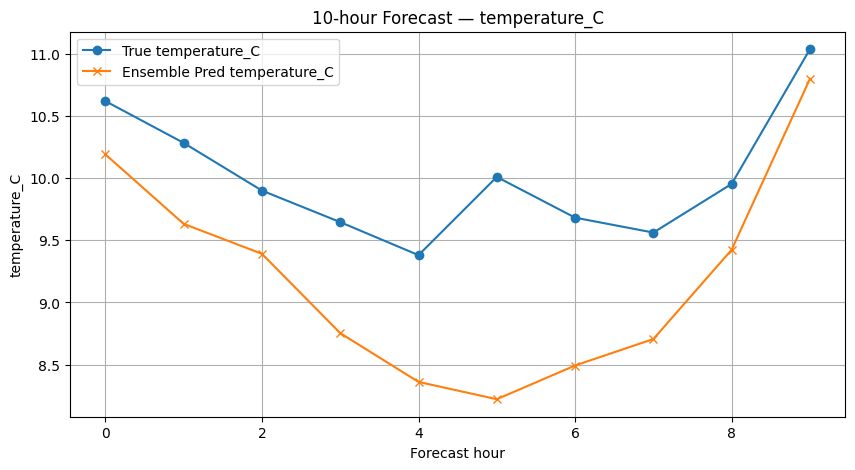

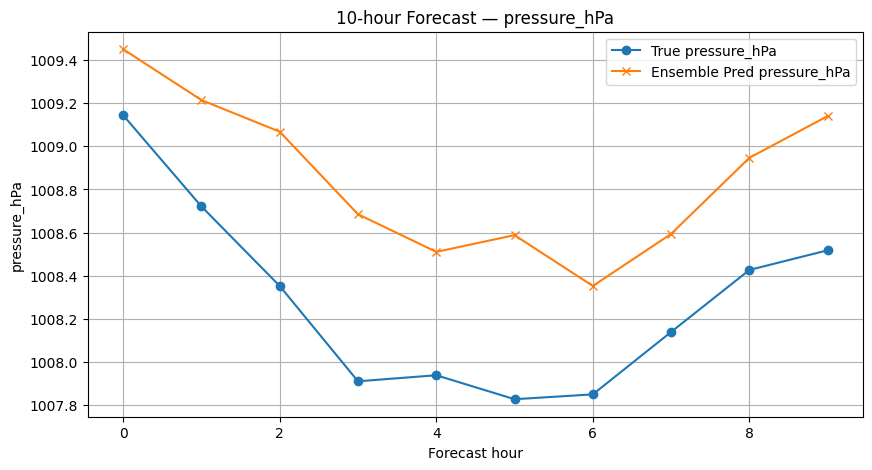

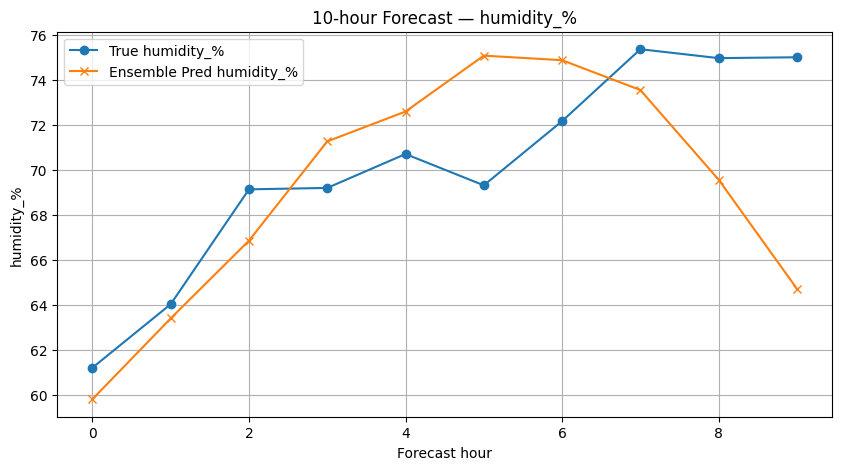

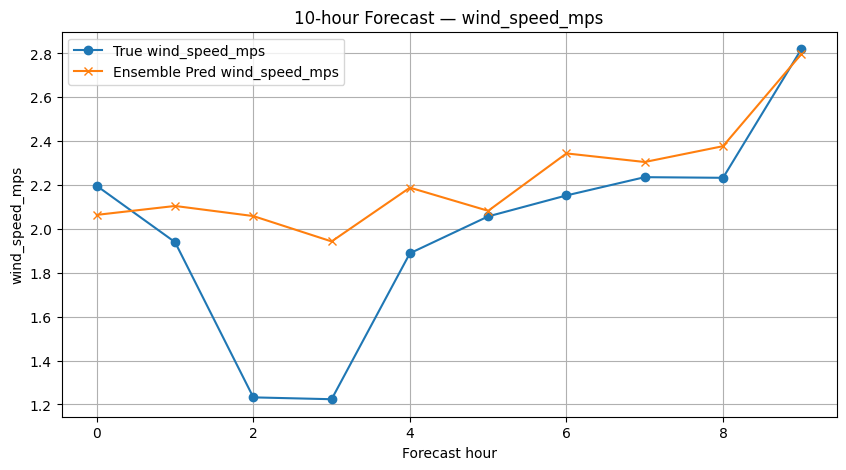

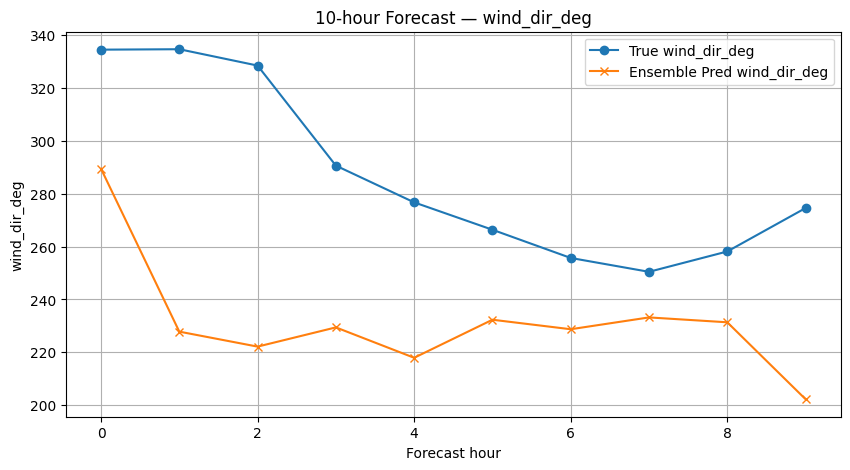

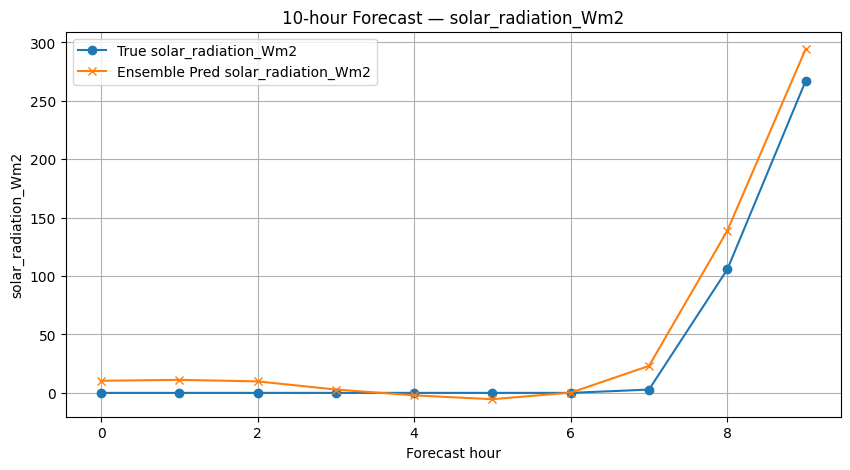

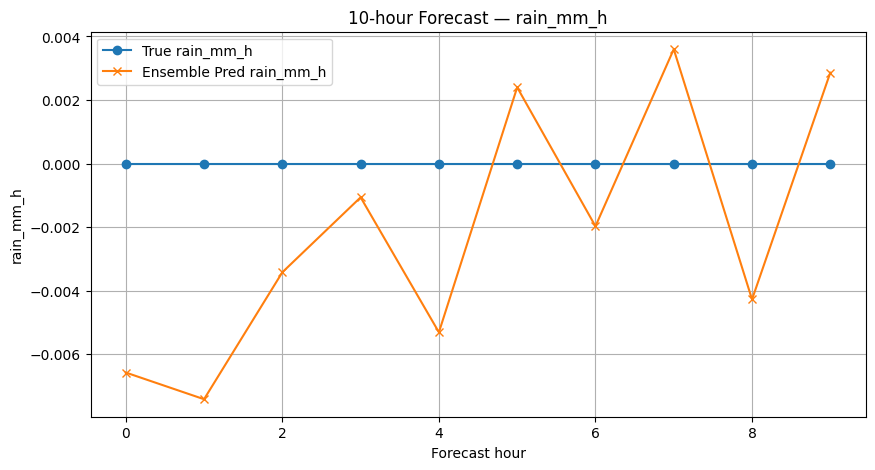

In [139]:
sample_idx = random.randint(0, y_test.shape[0]-1) # Get any sample of the test randomly
for i, feature in enumerate(weather_cols):
    plt.figure(figsize=(10,5))
    true_curve = y_true_2d[:10, i]    
    pred_curve = ens_2d[ :10, i] 
    plt.plot(true_curve, marker='o', label=f"True {feature}")
    plt.plot(pred_curve, marker='x', label=f"Ensemble Pred {feature}")
    plt.xlabel('Forecast hour')
    plt.ylabel(feature)
    plt.title(f"10-hour Forecast — {feature}")
    plt.legend()
    plt.grid(True)
    plt.show()


## Seq2Seq AutoEncoder

In [ ]:
# Use the same names and conversions for X & Y from ensemble models section
# x_train_notScaled ---> Not scaled, 3d
# x_train_2d ---> Not scaled, 2d
# x_train_s ---> Scaled, 3d
# X_train_reg ---> Scaled, 2d

In [ ]:
# seq2seq autoencoder model (Encoder LSTM -> RepeatVector -> Decoder LSTM)

In [105]:
# Building the Autoencoder
tf.keras.backend.clear_session()
inputs = Input(shape=(window_size, n_in_feats), name="encoder_input")
# Encoder
enc = LSTM(128, activation='tanh', name="encoder_lstm")(inputs)
# Decoder
repeat = RepeatVector(forecast_steps, name="repeat_vector")(enc) #(10) forecast steps
dec = LSTM(128, activation='tanh', return_sequences=True, name="decoder_lstm")(repeat)
outputs = TimeDistributed(Dense(n_targets), name="decoder_dense")(dec) 
# Apply dense layer for each time step separately

model = Model(inputs, outputs, name="seq2seq_autoencoder")
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "seq2seq_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 20, 13)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm (LSTM)             │ (None, 128)            │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense (TimeDistributed) │ (None, 10, 7)          │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,191 (801.53 KB)

 Trainable params: 205,191 (801.53 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    x_train_s, y_train_s,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

Epoch 1/100
519/519 - 7s - 14ms/step - loss: 0.0237 - mae: 0.0921 - val_loss: 0.0164 - val_mae: 0.0717
Epoch 2/100
519/519 - 4s - 7ms/step - loss: 0.0157 - mae: 0.0679 - val_loss: 0.0155 - val_mae: 0.0681
Epoch 3/100
519/519 - 3s - 7ms/step - loss: 0.0146 - mae: 0.0631 - val_loss: 0.0149 - val_mae: 0.0646
Epoch 4/100
519/519 - 3s - 7ms/step - loss: 0.0140 - mae: 0.0608 - val_loss: 0.0147 - val_mae: 0.0631
Epoch 5/100
519/519 - 3s - 7ms/step - loss: 0.0136 - mae: 0.0590 - val_loss: 0.0145 - val_mae: 0.0623
Epoch 6/100
519/519 - 3s - 7ms/step - loss: 0.0131 - mae: 0.0576 - val_loss: 0.0145 - val_mae: 0.0624
Epoch 7/100
519/519 - 3s - 7ms/step - loss: 0.0128 - mae: 0.0564 - val_loss: 0.0148 - val_mae: 0.0628
Epoch 8/100
519/519 - 3s - 7ms/step - loss: 0.0124 - mae: 0.0554 - val_loss: 0.0151 - val_mae: 0.0635
Epoch 9/100
519/519 - 3s - 7ms/step - loss: 0.0120 - mae: 0.0543 - val_loss: 0.0158 - val_mae: 0.0652
Epoch 10/100
519/519 - 3s - 7ms/step - loss: 0.0117 - mae: 0.0533 - val_loss: 0.0

In [107]:
y_pred_s = model.predict(x_test_s)   # shape (n_test, forecast_steps, n_targets)
print("Y_pred_s shape:", y_pred_s.shape)

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Y_pred_s shape: (4585, 10, 7)


In [108]:
# Using function inverse_preds_3d() from Ensemble models to inverse transform
y_pred = inverse_preds_3d(y_pred_s, scaler_y)      # back to original units
y_test_orig = inverse_preds_3d(y_test_s, scaler_y)  # true Y in original units

print("Y_pred shape (orig units):", y_pred.shape)

Y_pred shape (orig units): (4585, 10, 7)


In [109]:
# Convert to 2d for evaluation & Visualization
y_true_2d = y_test_orig.reshape(-1, n_targets)   # (n_test*forecast_steps, n_targets)
y_pred_2d = y_pred.reshape(-1, n_targets)

In [111]:
mae_overall = mean_absolute_error(y_true_2d, y_pred_2d)
# mape_overall = mean_absolute_percentage_error(y_true_2d, y_pred_2d) * 100
rmse_overall = np.sqrt(mean_squared_error(y_true_2d, y_pred_2d))
r2 = r2_score(y_true_2d, y_pred_2d)
print(f"Overall -> R2Score: {r2:.4f}, MAE: {mae_overall:.4f}, RMSE: {rmse_overall:.4f}")

Overall -> R2Score: 0.6691, MAE: 16.3476, RMSE: 44.0756


In [112]:
per_feature = []
for j in range(n_targets):
    mae_j = mean_absolute_error(y_true_2d[:, j], y_pred_2d[:, j])
    mape_j = mean_absolute_percentage_error(y_true_2d[:, j], y_pred_2d[:, j])
    rmse_j = np.sqrt(mean_squared_error(y_true_2d[:, j], y_pred_2d[:, j]))
    r2_j = r2_score(y_true_2d[:, j], y_pred_2d[:, j])
    per_feature.append((weather_cols[j], r2_j, mae_j, mape_j, rmse_j))
    
metrics_df = pd.DataFrame(per_feature, columns=['feature', 'R2Score','MAE', 'MAPE','RMSE'])
print(metrics_df)

               feature   R2Score        MAE          MAPE       RMSE
0        temperature_C  0.951440   1.218893  5.262360e-02   1.633299
1         pressure_hPa  0.889557   1.406357  1.405617e-03   1.706990
2           humidity_%  0.868586   5.468425  1.319165e-01   7.281612
3       wind_speed_mps  0.567092   0.697446  3.054127e-01   0.934664
4         wind_dir_deg  0.492752  63.462270  9.836996e+00  98.391160
5  solar_radiation_Wm2  0.970181  42.170462  2.659593e+16  62.115302
6            rain_mm_h -0.055817   0.009391  3.546669e+13   0.034846


In [113]:
metrics_df.to_csv('model_eval.csv', index=True)

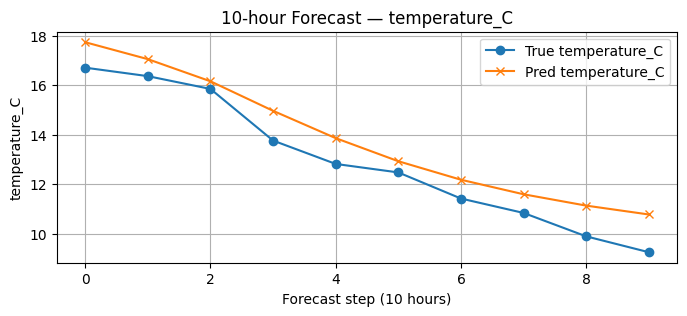

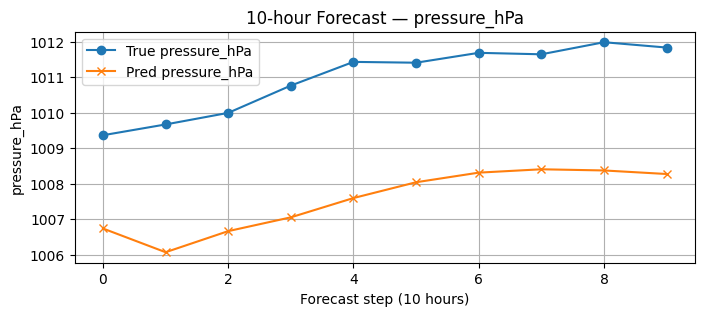

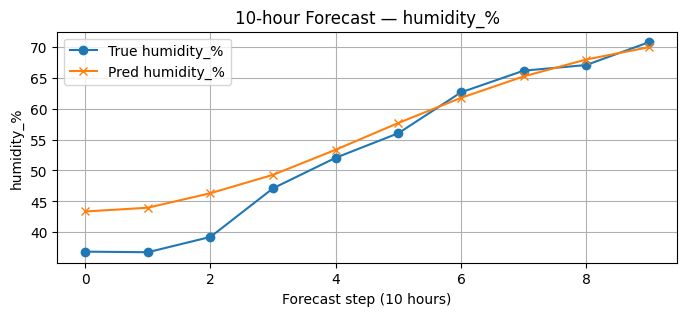

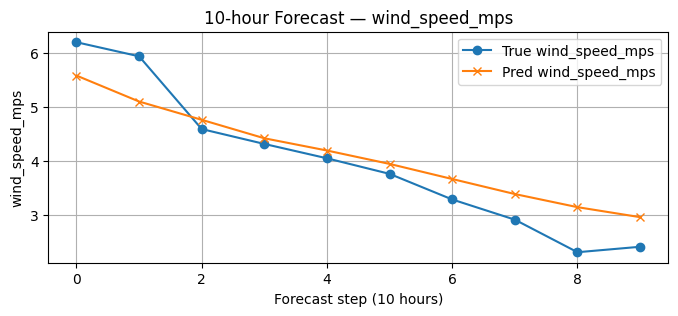

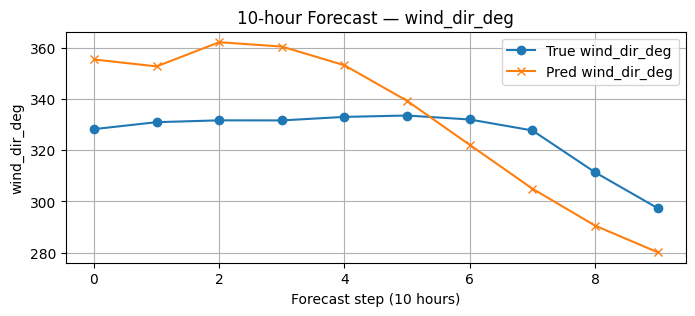

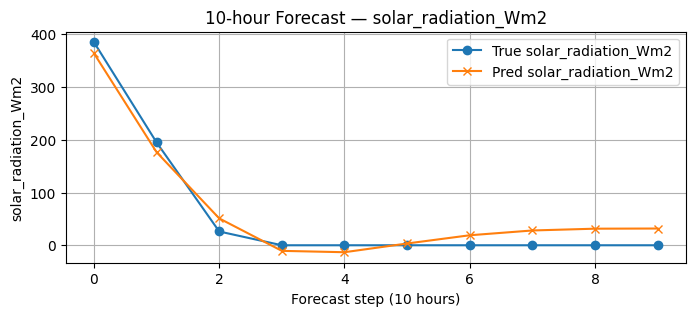

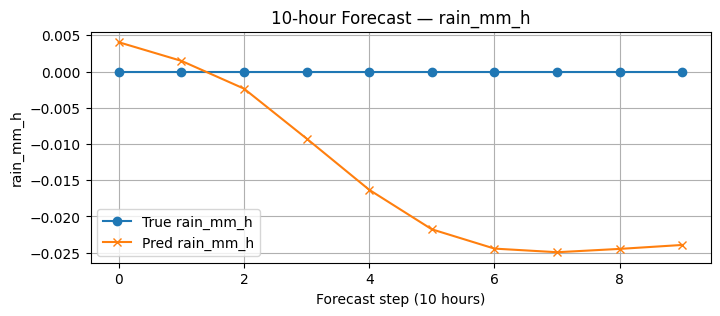

In [114]:
idx = random.randint(0, y_test.shape[0]-1) # Get any sample of the test randomly
for j, feat_name in enumerate(weather_cols):
    plt.figure(figsize=(8,3))
    true_curve = y_test_orig[idx, :, j]
    pred_curve = y_pred[idx, :, j]
    plt.plot(true_curve, marker='o', label=f"True {feat_name}")
    plt.plot(pred_curve, marker='x', label=f"Pred {feat_name}")
    plt.xlabel("Forecast step (10 hours)")
    plt.ylabel(feat_name)
    plt.title(f"10-hour Forecast — {feat_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [115]:
model.save("model.h5")
joblib.dump(scaler_x, 'scaler_x.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']